In [38]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from bs4 import BeautifulSoup

#Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

%matplotlib inline

## Summary of the main features 

|Dataset (site) |Name | Type  | Description   |
| -------- | -------- | -------- | -------- |
|beers.csv||||
|beers (Ba, Rb)|  abv  | Series - float  | Indicates the beer's alcohol by volume (%)|
|beers (Ba, Rb)|  avg  | Series - float  | Average rating given to the beer (averaging scores of different factors for each beer)|
|beers (Ba, Rb)|  avg_computed | Series - float  | ? |
|beers (Ba, Rb)|  avg_matched_valid_ratings | Series - float  | average of valid ratings (from users following certains criteria) |
|beers (Ba)|  ba_score  | Series - float  |Score for the beer advocate (ba) website|
|beers (Ba, Rb)|  beer_id  | Series - int  | Unique ID of each beer|
|beers (Ba, Rb)|  beer_name  | Series - string  | Name of the beer |
|beers (Ba, Rb)|  beer_wout_brewery_name  | Series - string  | name of the beer without the brewery name in it|
|beers (Ba, Rb)|  brewery_id  | Series - int  | Unique ID for each brewery the beers belong to|
|beers (Ba, Rb)|  brewery_name  | Series - string  | Name of the brewery|
|beers (Ba)|  bros_score  | Series - int  | score given by admins of the website |
|beers (Ba, Rb)|  nbr_matched_valid_ratings  | Series - int | number of valid ratings for this beer (rating/user follows certain criteria)|
|beers (Ba, Rb)|  nbr_ratings  | Series - int | total amount of ratigns for this beer |
|beers (Ba, Rb)|  nrb_reviews  | Series - int  | total number of text reviews for this beer|
|beers (Ba, Rb)| style |Series - string| style of beer (e.g. pale ale, irish dry stout...)|
|beers (Ba, Rb)| z_score |Series - float| standardized rating for this beer |
|beers (Rb)| overall_score | Series - float| average of the beer's overall rating given by the users|
|beers (Rb)| style_score | Series - float | average rating for beers of this style|
|beers| diff | Series - flaot| difference in score between Rb and Ba for this beer (between 0 and 1)|
|beers| sim | Series - float| similarity in score between Rb and Ba for this beer (between 0 and 1)|
| breweries.csv |  |  |  |
|breweries (Ba, Rb)| id |Series - int| unique ID for each brewery|
|breweries (Ba, Rb)| location |Series - string| full name of the state (USA) or country of origin of the brewery |
|breweries (Ba, Rb)| name |Series - string| full name of the brewery |
|breweries (Ba, Rb)| nbr_beers |Series - int| number of different beers brewed in this brewery|
| users.csv |  |  |  |
| users (Ba, Rb) | joined | Series - int | Unix timestamp for when the user joined the website |
| users (Ba, Rb) | location | Series - string | full name of the state (USA) or country of the user |
| users (Ba, Rb) | nbr_ratings | Series - int | total number of ratings given by the user |
| users (Ba, Rb) | nbr_reviews | Series - int | total number of rewviews given by the user |
| users (Ba, Rb) | user_id | Series - string | unique user ID in the format: username.ID |
| users (Ba, Rb) | user_name | Series - string | username |
| users (Ba, Rb) | user_name_lowercase | Series - string | username in lower case |

## Data preprocessing:

### Importing new datasets and cleaning them 

In [39]:
#wikipedia dataset for states (US) superficies
wiki_url_4usa = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area'
#Get the html of the pages
response_us = requests.get(wiki_url_4usa)
soup_us = BeautifulSoup(response_us.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
superficies_list_us = soup_us.find('table', attrs={'class':"wikitable"})
df_superficies_us = pd.read_html(str(superficies_list_us), header=1)[0]
display(df_superficies_us.columns)

#Clean the datafram
df_superficies_us = df_superficies_us[['State', 'km2']] #Keep only the columns we need
df_superficies_us['State'] = 'United States, ' + df_superficies_us['State'] #add the country name to be consistent with the other dataset
df_superficies_us = df_superficies_us.rename(columns={'State': 'location'}) #rename the column
df_superficies_us = df_superficies_us[:-3] #remove the last 3 rows (not states)
df_superficies_us['km2'] = df_superficies_us['km2'].astype(float) #convert the km2 column to float

#_______________________________________________________________________________________________________________________

#wikipedia dataset for country superficies
wiki_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area'

#Get the html of the pages
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
superficies_list = soup.find('table',attrs={'class':"wikitable"})
df_superficies = pd.read_html(str(superficies_list))[0]
display(df_superficies.columns)


#Keep only the columns we need and clean them
df_superficies = df_superficies[['Country / dependency', 'Total in km2 (mi2)']]
df_superficies.rename(columns={'Country / dependency':'location', 'Total in km2 (mi2)':'km2'}, inplace=True) #rename the columns
df_superficies['km2'] = df_superficies['km2'].str.replace(',', '') #remove the comma
df_superficies['km2'] = df_superficies['km2'].str.split(' ').str[0]  #remove the text in parenthesis (mi2)
df_superficies['location'] = df_superficies['location'].str.replace(r'\s*\([^)]*\)', '', regex=True)  #Remove all parenthesis and text inside in the location (ex : remove (China) in 'Hong Kong (China)')
df_superficies['km2'] = df_superficies['km2'].astype(float) #convert the km2 column to int

#Change the name of the countries to be consistent with the other dataset
df_superficies.location = df_superficies.location.replace({'Slovakia' : 'Slovak Republic', 'North Macedonia' : 'Macedonia', 'Trinidad and Tobago' : 'Trinidad & Tobago'})

#________________________________________________________________

#Dataset for UK coutries superficies to be consistent with the other dataset (breweries and beers)
df_superficies_uk = pd.DataFrame({'location': ['England', 'Scotland', 'Wales', 'Northern Ireland'], 
                                  'km2': [130279, 78772, 20779, 14130]}) #create the dataframe (small so easy to do it manually)

#_______________________________________________________________________________________________________________________

#Concatenate the two first dataframe 
df_superficies_temp = pd.concat([df_superficies, df_superficies_us]) #concatenate the two dataframe
print(np.shape(df_superficies_temp))

#Merging the dataframes with the UK dataframe
df_superficies_tot = pd.concat([df_superficies_temp, df_superficies_uk])
print(np.shape(df_superficies_tot))

C:\Users\nicol\AppData\Local\Temp\ipykernel_21004\3756883540.py:9: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Index(['State', 'Rank', 'sq mi', 'km2', 'Rank.1', 'sq mi.1', 'km2.1', '% land',
       'Rank.2', 'sq mi.2', 'km2.2', '% water'],
      dtype='object')

C:\Users\nicol\AppData\Local\Temp\ipykernel_21004\3756883540.py:30: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



Index(['Unnamed: 0', 'Country / dependency', 'Total in km2 (mi2)',
       'Land in km2 (mi2)', 'Water in km2 (mi2)', '% water', 'Unnamed: 6'],
      dtype='object')

(322, 2)
(326, 2)


In [87]:
#Wikipedia datasets for the population of the countries
wiki_url_pop = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

#Get the html of the pages
response_pop = requests.get(wiki_url_pop)
soup_pop = BeautifulSoup(response_pop.text,'lxml')

#Find the useful table from in the html and convert it into pandas df 
population = soup_pop.find("table", attrs={"class": "wikitable"})
df_population = pd.read_html(str(population))[0]
df_population = df_population[['Country / Dependency', 'Population']] #Keep only the columns we need
df_population.rename(columns = {'Country / Dependency' : 'location', 'Population' : 'population'}, inplace=True) #rename the columns

#Change the name of the countries to be consistent with the other dataset
df_population.location = df_population.location.replace({'Slovakia' : 'Slovak Republic', 
                                                           'North Macedonia' : 'Macedonia', 
                                                           'Trinidad and Tobago' : 'Trinidad & Tobago', 
                                                           'Puerto Rico (US)' : 'Puerto Rico',
                                                           'Jersey (UK)' : 'Jersey', 
                                                           'Faroe Islands (Denmark)' : 'Faroe Islands'})


#_______________________________________________________________________________________________________________________

#Wikipedia dataset for the population of the US states
wiki_url_pop_US = "https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population"

#Get the html of the pages
response_pop_US = requests.get(wiki_url_pop_US)
soup_pop_US = BeautifulSoup(response_pop_US.text,'lxml')

#Find the useful table from in the html and convert it into pandas df
population_US = soup_pop_US.find("table", attrs={"class": "wikitable"})
df_population_US = pd.read_html(str(population_US))[0]
df_population_US = df_population_US[['State', 'Census population, April 1, 2020 [1][2]']] #Keep only the columns we need
df_population_US.rename(columns={'State' : 'location', 'Census population, April 1, 2020 [1][2]' : 'population'}, inplace = True)
df_population_US['location'] = 'United States, ' + df_population_US['location'] #add the country name to be consistent with the other dataset
df_population_US = df_population_US[:-4] #remove the last 4 rows (not states)

#_______________________________________________________________________________________________________________________

#Wikipedia dataset for the population of the UK countries

df_population_UK = pd.DataFrame({'location': ['England', 'Scotland', 'Wales', 'Northern Ireland'], 
                                 'population' : [56550138, 5463300, 3152879, 1893667]}) #create the dataframe (small so easy to do it manually)


#_______________________________________________________________________________________________________________________

# Concatenate the two first dataframe 
df_population_tot = pd.concat([df_population, df_population_US]) #concatenate the two dataframe

# Concatenate the previous df with the one from UK and reset index
df_population_tot = pd.concat([df_population_tot, df_population_UK])
df_population_tot.reset_index(drop=True, inplace=True)



C:\Users\nicol\AppData\Local\Temp\ipykernel_21004\2783564457.py:10: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\nicol\AppData\Local\Temp\ipykernel_21004\2783564457.py:34: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



### Matched websites 

#### Loading the data

In [ ]:
#RateBeer and Beer Advocate matched website data :

df_beer = pd.read_csv("matched_beer_data/beers.csv", header=1)
df_breweries  = pd.read_csv("matched_beer_data/breweries.csv", header=1)
df_users = pd.read_csv("matched_beer_data/users.csv", header=1)
df_rating = pd.read_csv("matched_beer_data/ratings.csv", header=1)
df_users_approx = pd.read_csv("matched_beer_data/users_approx.csv", header=1)

#### Merging, cleaning and visualize the matched datasets (beers and breweries)

In [ ]:
#Merge the two dataframes on the brewery_id column with respect to the beers to have access to the location of every beer
df_beer_breweries = pd.merge(df_beer, df_breweries, left_on='brewery_id', right_on='id', how='left')

#Clean the dataframe by dropping the columns that are not useful for the analysis
df_beer_breweries_clean = df_beer_breweries.drop(['beer_wout_brewery_name', 'beer_wout_brewery_name.1', 'style','abv.1', 'id', 'id.1', 'name', 'name.1', 'beer_name.1', 'brewery_name.1', 'location.1', 'nbr_beers.1'], axis=1)


#Choose to keep style from RateBeer and drop the style from Beer Advocate (the style from Beer Advocate is too precise)
df_beer_breweries_clean.rename(columns={'style.1':'style'}, inplace=True)

#In the data set, the features with .1 at the end are the ones from Beer Advocate and the ones without .1 are the ones from RateBeer

#### Merging and cleaning the matched datasets (superficies and breweries)

In [ ]:
#Merge the dataframe with the superficies dataframe to have access to the superficies of every beer
df_breweries_superficies = pd.merge(df_breweries, df_superficies_tot, on='location', how='left')

#Drop row with NaN values in km2 column
df_breweries_superficies = df_breweries_superficies.dropna(subset=['km2'])

#Drop the location with less than 5 breweries (to do a beer trip, we need to have different breweries to visit!)
df_breweries_superficies_flt = df_breweries_superficies.groupby('location').filter(lambda x: len(x) >= 5)

#In the data set, the features with .1 at the end are the ones from Beer Advocate and the ones without .1 are the ones from RateBeer

#### Merging and cleaning the dataset about users

We need to merge it with the dataframe imported from Wikipedia with the population of the locations, because the goal of this preprocessing is to express finally the places where there are the biggest amount of "expert" per capita. 

In [110]:
#Selection of the columns to keep and rename them
df_users_approx_flt = df_users_approx[['location', 'user_id', 'user_name', 'nbr_ratings', 'nbr_ratings.1']]
df_users_approx_flt = df_users_approx_flt.rename(columns={'nbr_ratings':'nbr_ratings_beer_advocate', 'nbr_ratings.1':'nbr_ratings_ratebeer'})


#Check that every user has at least one rating in each website (insure that the user is active)
df_users_approx_flt = df_users_approx_flt.drop(df_users_approx_flt[(df_users_approx_flt['nbr_ratings_beer_advocate'] == 0) | (df_users_approx_flt['nbr_ratings_ratebeer'] == 0)].index)  # Drop rows where there is no ratings in one of the two websites

#Merge the dataframe with the population dataframe to have access to the population of every country
df_users_pop = pd.merge(df_users_approx_flt, df_population_tot, on='location', how='left')


,location,user_id,user_name,nbr_ratings_beer_advocate,nbr_ratings_ratebeer,population
0,Spain,magicuenca.1185749,MAGICuenca,3,89,48345223
1,Germany,erzengel.248045,Erzengel,6,8781,84482267
2,"United States, Virginia",gendv138.695700,GenDV138,1,6240,8631393
3,"United States, Washington",nimbleprop.208928,nimbleprop,3,7452,7705281
4,Estonia,visionthing.639993,visionthing,11,5462,1365884
...,...,...,...,...,...,...
3336,"United States, Michigan",ypsifly.8833,ypsifly,587,1,10077331
3337,"United States, Texas",hardtarget.1712,HardTarget,1379,1,29145505
3338,"United States, Delaware",deadterry.13629,DeadTerry,1,2,989948
3339,Vietnam,nelsonsaigon.897449,nelsonsaigon,176,1,100000000


### RateBeer Website

#### Loading the datasets from RateBeer and drop nan values

In [ ]:
#RateBeer website data :

df_beer_RB = pd.read_csv("RateBeer/beers.csv", index_col='beer_id')
df_breweries_RB  = pd.read_csv("RateBeer/breweries.csv")
df_users_RB = pd.read_csv("RateBeer/users.csv")

#Remove raws with NaN values
df_beer_RB= df_beer_RB.dropna(subset=["zscore"])


#### Data exploration on df_beer

We decided to work with the data of each website separatly to take into account users which would only be active on one site. This will allow us to later compare the best beers for our world tour.
Here we don't care about the z-score and the rating score because we will recompute them based only on the best reviewers. We just clean and explore the data from the beers and the users that are not relevant.

First we explore the nbr_ratings per beer, the basic descriptive statistics, it's distribution and some visualization. 

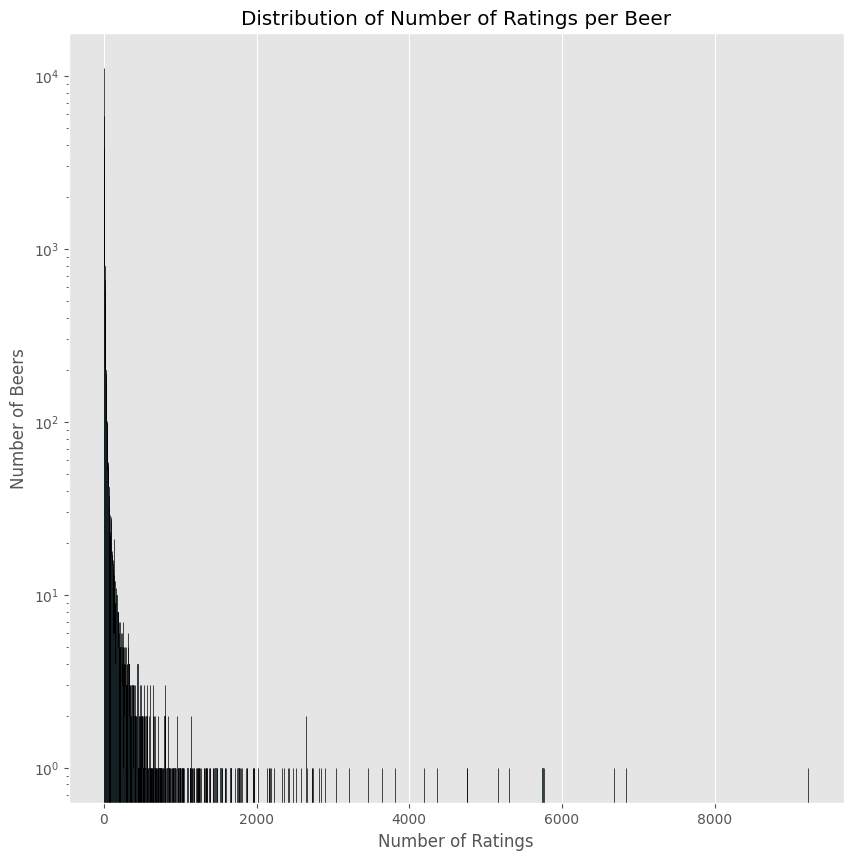

In [ ]:
# Count the number of beers for each number of ratings
reviews_counts = df_beer_RB['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.yscale('log')
plt.title('Distribution of Number of Ratings per Beer')
plt.grid(axis='y')
plt.show()

In [ ]:
# Get an idea of the distribution of the number of ratings per beer

# Choose different quantile thresholds 
ratings_threshold75 = df_beer_RB['nbr_ratings'].quantile(0.75)
ratings_threshold90 = df_beer_RB['nbr_ratings'].quantile(0.90)
ratings_threshold95 = df_beer_RB['nbr_ratings'].quantile(0.95)
ratings_threshold98 = df_beer_RB['nbr_ratings'].quantile(0.98)
ratings_threshold99 = df_beer_RB['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_beers75 = df_beer_RB[df_beer_RB['nbr_ratings'] >= ratings_threshold75]
filtered_beers90 = df_beer_RB[df_beer_RB['nbr_ratings'] >= ratings_threshold90]
filtered_beers95 = df_beer_RB[df_beer_RB['nbr_ratings'] >= ratings_threshold95]
filtered_beers98 = df_beer_RB[df_beer_RB['nbr_ratings'] >= ratings_threshold98]
filtered_beers99 = df_beer_RB[df_beer_RB['nbr_ratings'] >= ratings_threshold99]

print(filtered_beers75.shape,
filtered_beers90.shape,
filtered_beers95.shape,
filtered_beers98.shape,
filtered_beers99.shape)


(10498, 14) (4086, 14) (2026, 14) (807, 14) (404, 14)


Note: we see that even by taking the top 5% of most rated beers (highest nbr_ratings) we still have 2142 beers. 

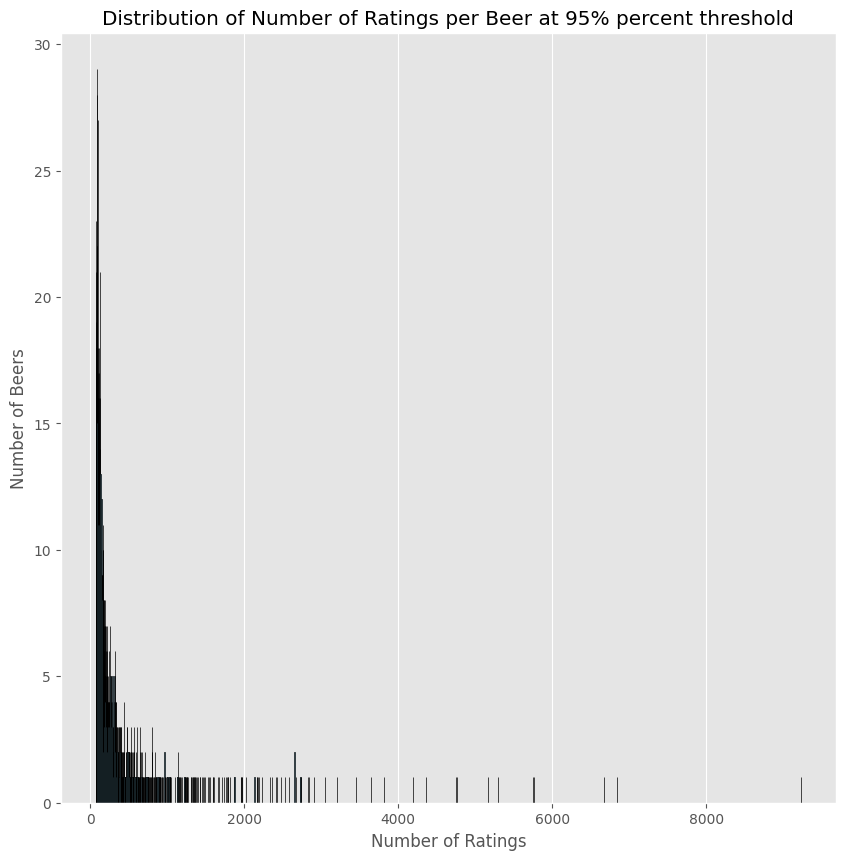

count    45640.000000
mean        20.945837
std        137.768038
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       9228.000000
Name: nbr_ratings, dtype: float64

count    2026.000000
mean      323.123889
std       573.835275
min        75.000000
25%       103.000000
50%       156.000000
75%       301.000000
max      9228.000000
Name: nbr_ratings, dtype: float64

In [ ]:
# Create a new DataFrame with beers in the 95th percentile
df_filtered_beer = filtered_beers95

# Count the number of beers for each number of ratings
reviews_counts = df_filtered_beer['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.title('Distribution of Number of Ratings per Beer at 95% percent threshold')
plt.grid(axis='y')
plt.show()

# Get an idea of the distribution of the number of ratings per beer
display(df_beer['nbr_ratings'].describe())
display(df_filtered_beer['nbr_ratings'].describe())


Next we explore the zscore per beer, the basic descriptive statistics, it's distribution and some visualization. Will allow us later, when we recompute the new z-scores with the most active reviewer to compare them. 

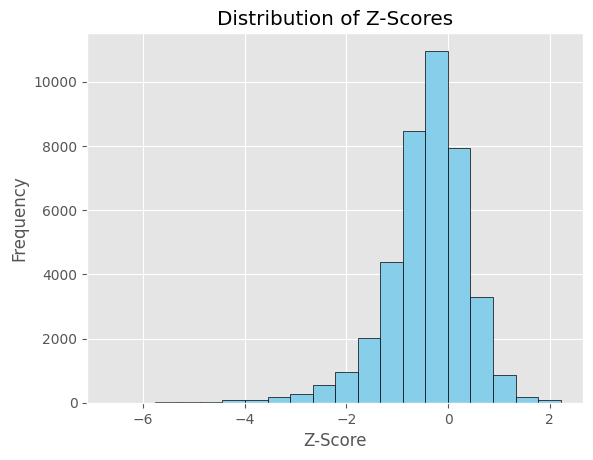

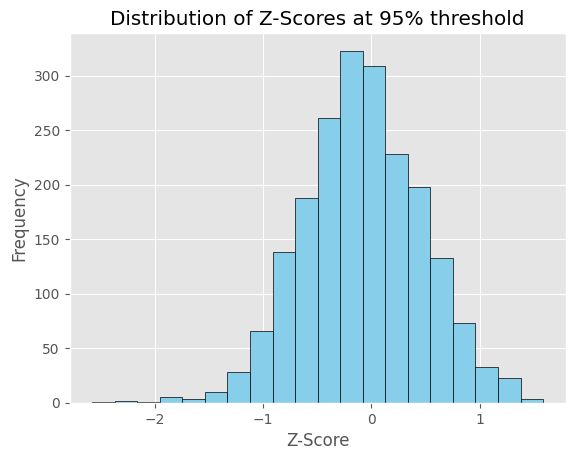

In [ ]:
# Visualize the z-score distribution 

plt.hist(df_beer_RB['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores')
plt.show()

# Visualize the z-score distribution at 95% threshold 

plt.hist(df_filtered_beer['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores at 95% threshold')
plt.show()

We can notice that for beers with nbr_ratings > 96 (the minimum number of ratings for the top 5% most rated beer) the z-score spreads a bit less. 


#### Data exploration on df_user

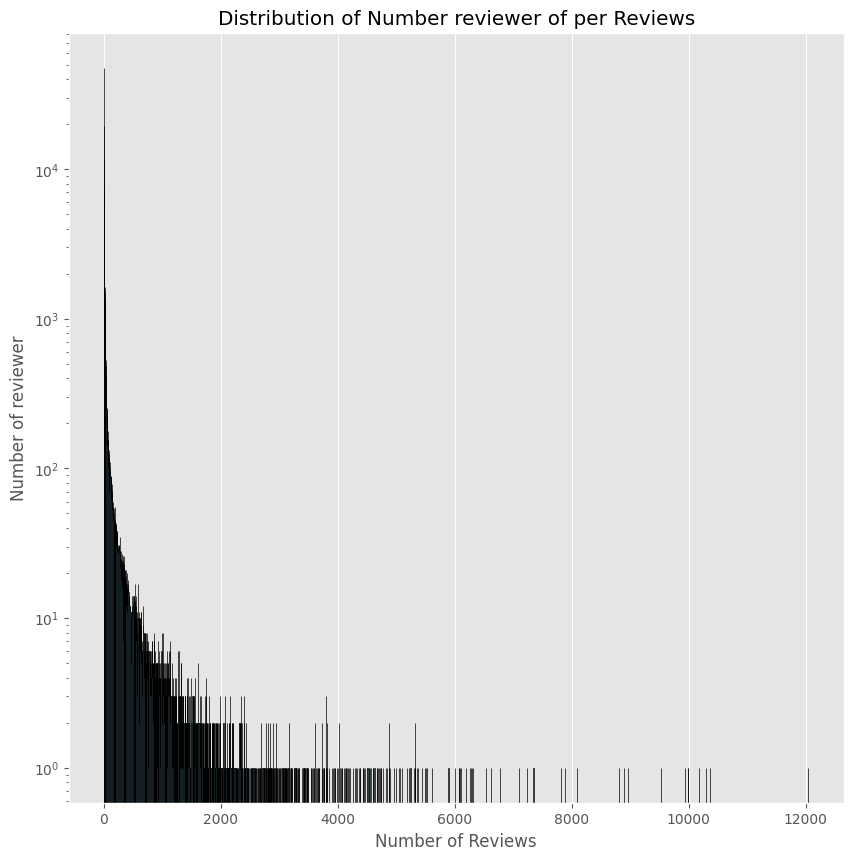

In [ ]:
# Count the number of beers for each number of ratings
reviews_counts = df_users_RB['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.yscale('log')
plt.title('Distribution of Number reviewer of per Reviews')
plt.grid(axis='y')
plt.show()

In [ ]:
# Choose a percentile threshold (adjust as needed)
ratings_threshold75 = df_users_RB['nbr_ratings'].quantile(0.75)
ratings_threshold90 = df_users_RB['nbr_ratings'].quantile(0.90)
ratings_threshold95 = df_users_RB['nbr_ratings'].quantile(0.95)
ratings_threshold98 = df_users_RB['nbr_ratings'].quantile(0.98)
ratings_threshold99 = df_users_RB['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_users75 = df_users_RB[df_users_RB['nbr_ratings'] >= ratings_threshold75]
filtered_users90 = df_users_RB[df_users_RB['nbr_ratings'] >= ratings_threshold90]
filtered_users95 = df_users_RB[df_users_RB['nbr_ratings'] >= ratings_threshold95]
filtered_users98 = df_users_RB[df_users_RB['nbr_ratings'] >= ratings_threshold98]
filtered_users99 = df_users_RB[df_users_RB['nbr_ratings'] >= ratings_threshold99]

print(filtered_users75.shape,
filtered_users90.shape,
filtered_users95.shape,
filtered_users98.shape,
filtered_users99.shape)

(38679, 6) (15415, 6) (7708, 6) (3075, 6) (1542, 6)


702 users are in the top 1% of the most active users (thus the one having the highest nbr_ratings) 

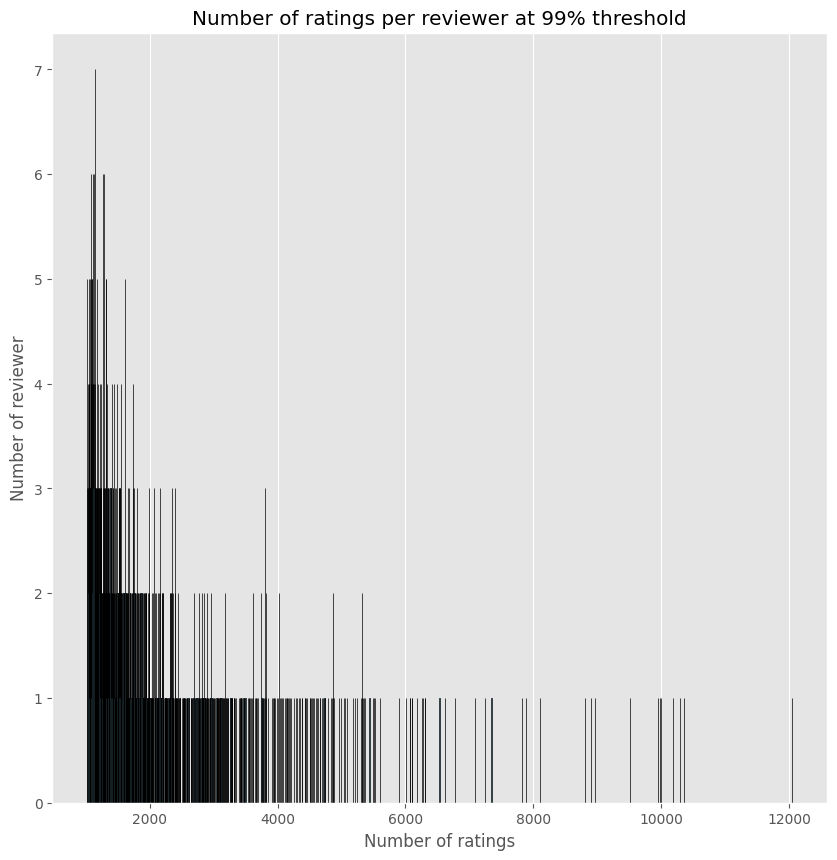

count     1542.000000
mean      1965.327497
std       1250.713955
min       1023.000000
25%       1221.000000
50%       1538.000000
75%       2186.250000
max      12046.000000
Name: nbr_ratings, dtype: float64

In [ ]:
# Create a new DataFrame with beers in the 95th percentile
df_filtered_users = filtered_users99

# Count the number of beers for each number of ratings
reviews_counts = df_filtered_users['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of ratings')
plt.ylabel('Number of reviewer')
plt.title('Number of ratings per reviewer at 99% threshold')
plt.grid(axis='y')
plt.show()

# Get an idea of the distribution of the number of ratings per beer
df_users_RB['nbr_ratings'].describe()
df_filtered_users['nbr_ratings'].describe()



### BeerAdvocate website

#### Loading the datasets from BeerAdvocate and drop nan values

In [ ]:
#RateBeer website data :
df_beer_BA = pd.read_csv("BeerAdvocate/beers.csv", index_col='beer_id')
df_breweries_BA  = pd.read_csv("BeerAdvocate/breweries.csv")
df_users_BA = pd.read_csv("BEerAdvocate/users.csv")

#Remove raws with NaN values
df_beer_BA= df_beer_BA.dropna(subset=["zscore"])

#### Data exploration on df_beer_BA

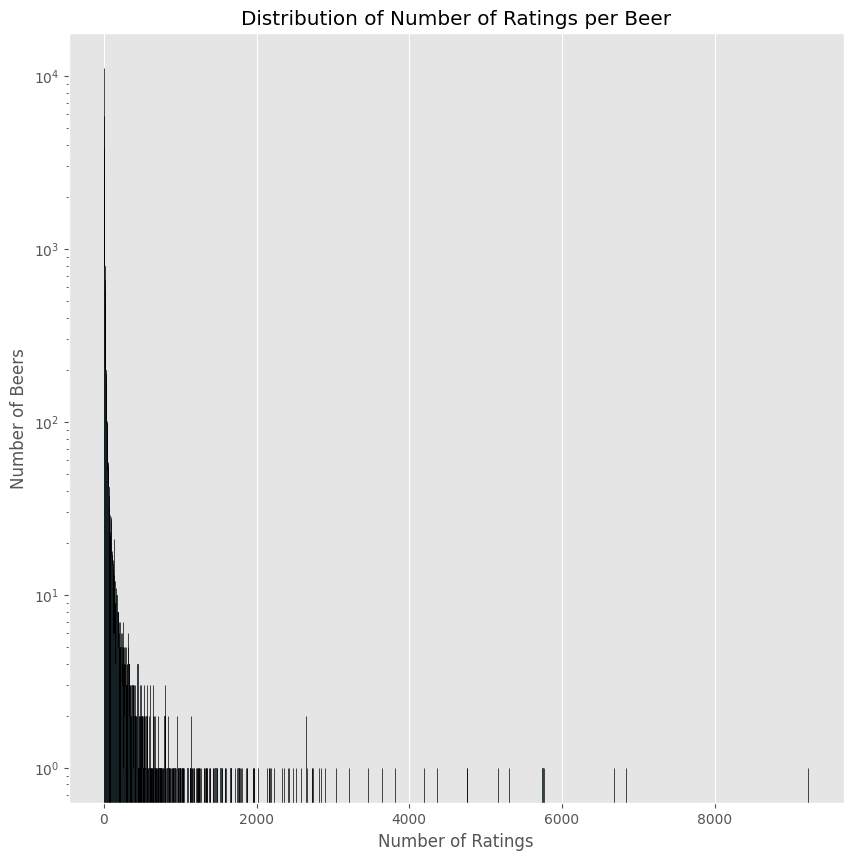

In [ ]:
# Count the number of beers for each number of ratings
reviews_counts = df_beer_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.yscale('log')
plt.title('Distribution of Number of Ratings per Beer')
plt.grid(axis='y')
plt.show()

In [ ]:
# Get an idea of the distribution of the number of ratings per beer

# Choose different quantile thresholds 
ratings_threshold75_BA = df_beer_BA['nbr_ratings'].quantile(0.75)
ratings_threshold90_BA = df_beer_BA['nbr_ratings'].quantile(0.90)
ratings_threshold95_BA = df_beer_BA['nbr_ratings'].quantile(0.95)
ratings_threshold98_BA = df_beer_BA['nbr_ratings'].quantile(0.98)
ratings_threshold99_BA = df_beer_BA['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_beers75_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold75_BA]
filtered_beers90_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold90_BA]
filtered_beers95_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold95_BA]
filtered_beers98_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold98_BA]
filtered_beers99_BA = df_beer_BA[df_beer_BA['nbr_ratings'] >= ratings_threshold99_BA]

print(filtered_beers75_BA.shape,
filtered_beers90_BA.shape,
filtered_beers95_BA.shape,
filtered_beers98_BA.shape,
filtered_beers99_BA.shape)

(10498, 14) (4086, 14) (2026, 14) (807, 14) (404, 14)


Note: we see that even by taking the top 5% of most rated beers we still have 2026 beers. If we compare this results to the one found in RateBeer, we have roughly the same amount of the nbr_ratings for the top 5% rated beer.


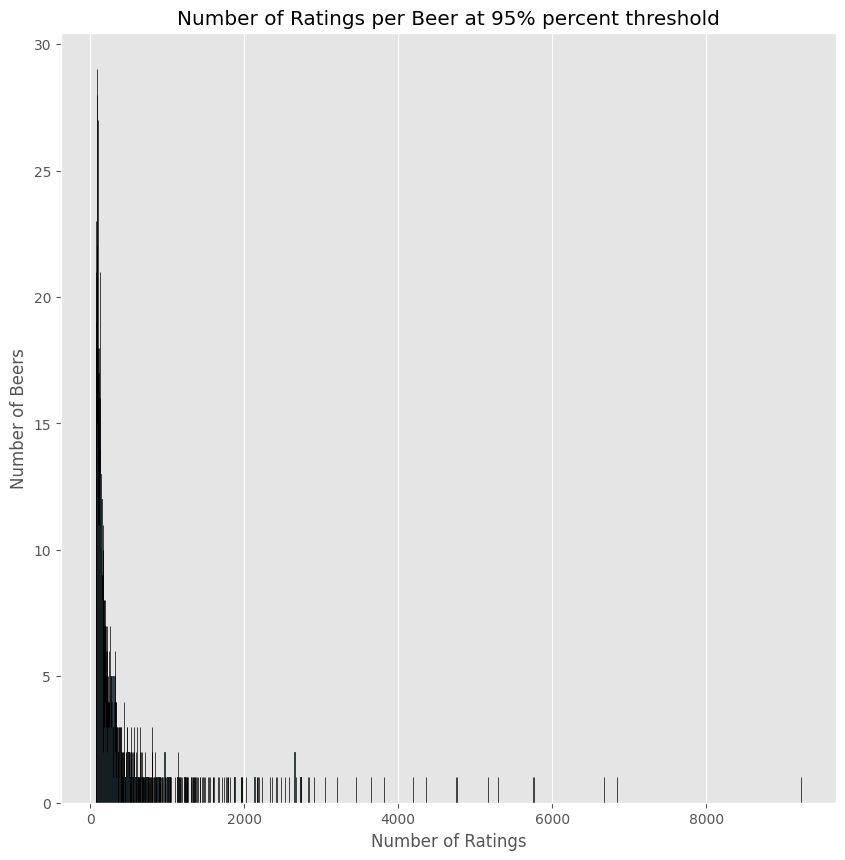

count    40285.000000
mean        23.730123
std        146.413789
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max       9228.000000
Name: nbr_ratings, dtype: float64

count    2026.000000
mean      323.123889
std       573.835275
min        75.000000
25%       103.000000
50%       156.000000
75%       301.000000
max      9228.000000
Name: nbr_ratings, dtype: float64

In [ ]:
# Create a new DataFrame with beers in the 95th percentile
df_filtered_beer_BA = filtered_beers95_BA

# Count the number of beers for each number of ratings
reviews_counts = df_filtered_beer_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Beers')
plt.title('Number of Ratings per Beer at 95% percent threshold')
plt.grid(axis='y')
plt.show()

# Get an idea of the distribution of the number of ratings per beer
display(df_beer_BA['nbr_ratings'].describe(),
df_filtered_beer_BA['nbr_ratings'].describe())



Gives us an idea of the distribution of the most rated beers (nbr_ratings) and the maximum/minimum nbr_ratings of the top 5% most rated beer. Roughly the same amount of minimum of ratings (75 here vs 96 in RateBeer). 


Next we explore the zscore per beer, the basic descriptive statistics, it's distribution and some visualization. Will allow us later, when we recompute the new z-scores with the most active reviewer to compare them. 

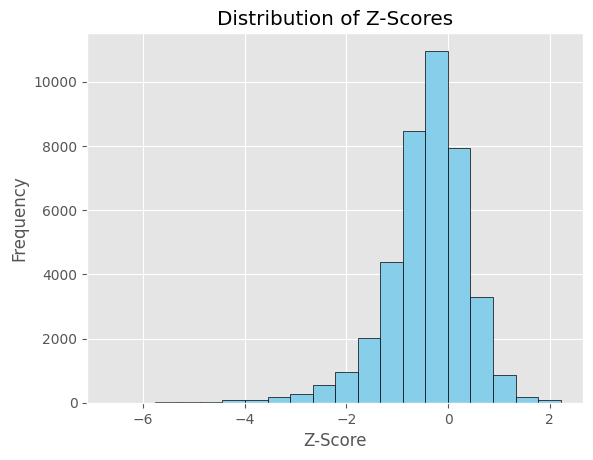

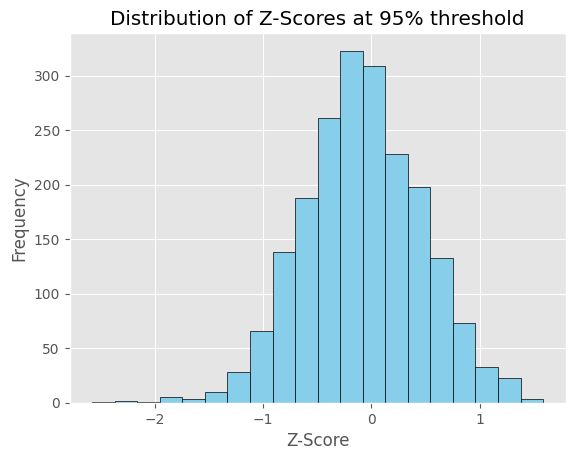

count    40285.000000
mean        -0.408295
std          0.806491
min         -6.655704
25%         -0.785424
50%         -0.321596
75%          0.086733
max          2.211576
Name: zscore, dtype: float64

count    2026.000000
mean       -0.081419
std         0.548701
min        -2.581808
25%        -0.450519
50%        -0.089859
75%         0.298036
max         1.587798
Name: zscore, dtype: float64

In [ ]:
# Visualize the z-score distribution 

plt.hist(df_beer_BA['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores')
plt.show()


# Visualize the z-score distribution at 95% threshold 

plt.hist(df_filtered_beer_BA['zscore'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-Scores at 95% threshold')
plt.show()

# Describe the z-score distribution
display(df_beer_BA['zscore'].describe(),
df_filtered_beer_BA['zscore'].describe())

#### Data exploration on df_user_BA

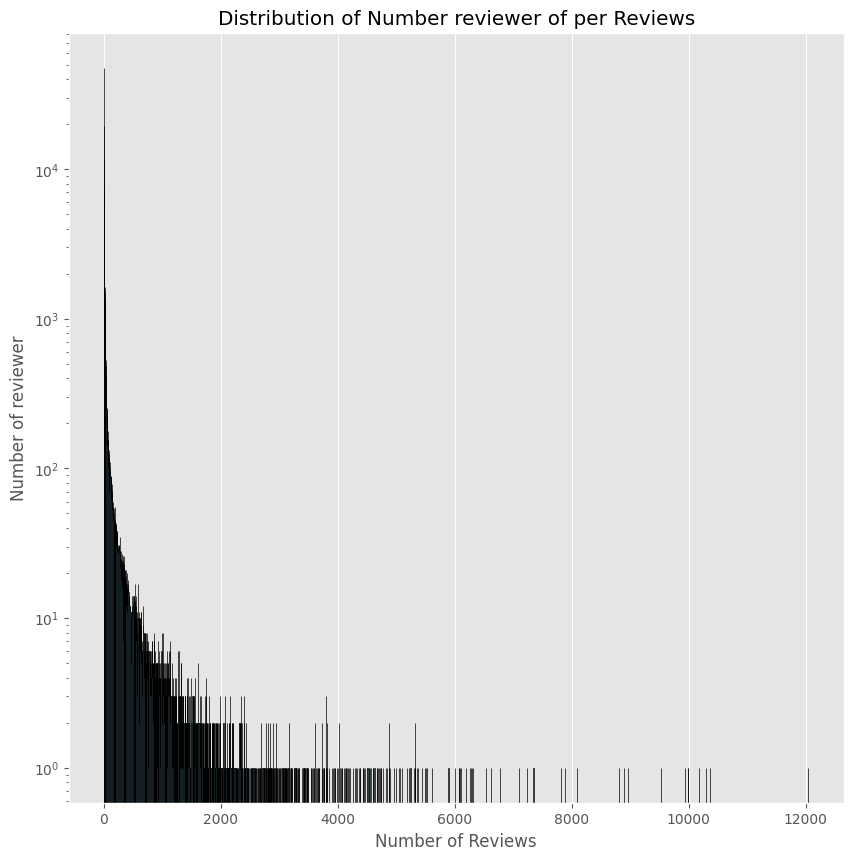

In [ ]:
# Count the number of beers for each number of ratings
reviews_counts = df_users_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.yscale('log')
plt.title('Distribution of Number reviewer of per Reviews')
plt.grid(axis='y')
plt.show()



In [ ]:
# Get an idea of the distribution of the number of ratings per beer

# Choose different quantile thresholds 
ratings_threshold75_BA = df_users_BA['nbr_ratings'].quantile(0.75)
ratings_threshold90_BA = df_users_BA['nbr_ratings'].quantile(0.90)
ratings_threshold95_BA = df_users_BA['nbr_ratings'].quantile(0.95)
ratings_threshold98_BA = df_users_BA['nbr_ratings'].quantile(0.98)
ratings_threshold99_BA = df_users_BA['nbr_ratings'].quantile(0.99)

# Filter beers based on the threshold
filtered_users75_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold75_BA]
filtered_users90_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold90_BA]
filtered_users95_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold95_BA]
filtered_users98_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold98_BA]
filtered_users99_BA = df_users_BA[df_users_BA['nbr_ratings'] >= ratings_threshold99_BA]

print(filtered_beers75_BA.shape,
filtered_users90_BA.shape,
filtered_users95_BA.shape,
filtered_users98_BA.shape,
filtered_users99_BA.shape)

(10498, 14) (15415, 6) (7708, 6) (3075, 6) (1542, 6)


We have 1542 users at the top 1% of nbr_ratings. 


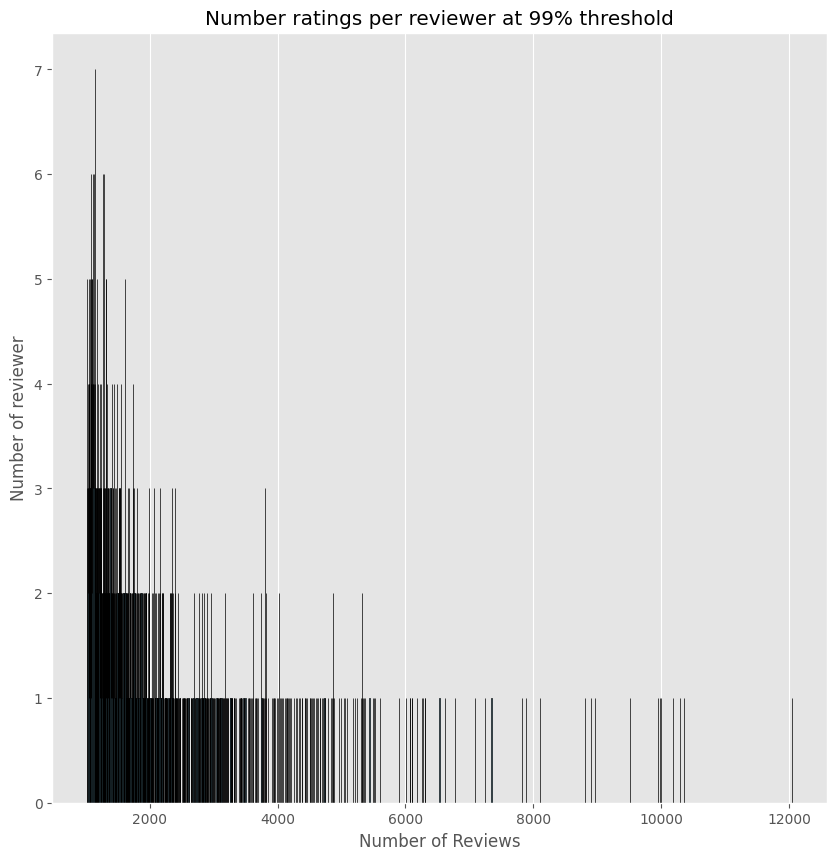

count    153704.000000
mean         54.605163
std         252.388790
min           1.000000
25%           1.000000
50%           3.000000
75%          16.000000
max       12046.000000
Name: nbr_ratings, dtype: float64

count     1542.000000
mean      1965.327497
std       1250.713955
min       1023.000000
25%       1221.000000
50%       1538.000000
75%       2186.250000
max      12046.000000
Name: nbr_ratings, dtype: float64

nbr_ratings           12046
nbr_reviews            7593
user_id          sammy.3853
user_name             Sammy
joined         1070276400.0
location             Canada
Name: 228, dtype: object

nbr_ratings                       1023
nbr_reviews                         71
user_id             stampfler07.154141
user_name                  stampfler07
joined                    1187604000.0
location       United States, Colorado
Name: 586, dtype: object

In [ ]:
# Create a new DataFrame with beers in the 99th percentile
df_filtered_users_BA = filtered_users99_BA

# Count the number of beers for each number of ratings
reviews_counts = df_filtered_users_BA['nbr_ratings'].value_counts().sort_index()

# Plot the distribution of number of ratings per beer
plt.figure(figsize=(10,10))
plt.bar(reviews_counts.index, reviews_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of reviewer')
plt.title('Number ratings per reviewer at 99% threshold')
plt.grid(axis='y')
plt.show()

# Get an idea of the distribution of the number of ratings per beer
display(df_users_BA['nbr_ratings'].describe(),
df_filtered_users_BA['nbr_ratings'].describe())

# Display the most rated beer and the less rated one.
display(df_filtered_users_BA.loc[df_filtered_users_BA['nbr_ratings'].idxmax()],
df_filtered_users_BA.loc[df_filtered_users_BA['nbr_ratings'].idxmin()])

## Start to build our different trips

**USER PER CAPITA**

location
Argentina                        46654581.0
Australia                        26461912.0
Austria                           9129652.0
Belarus                           9200617.0
Belgium                          11772639.0
                                   ...     
United States, West Virginia      1793716.0
United States, Wisconsin          5893718.0
United States, Wyoming             576851.0
Uruguay                           3566550.0
Vietnam                         100000000.0
Name: population, Length: 111, dtype: float64

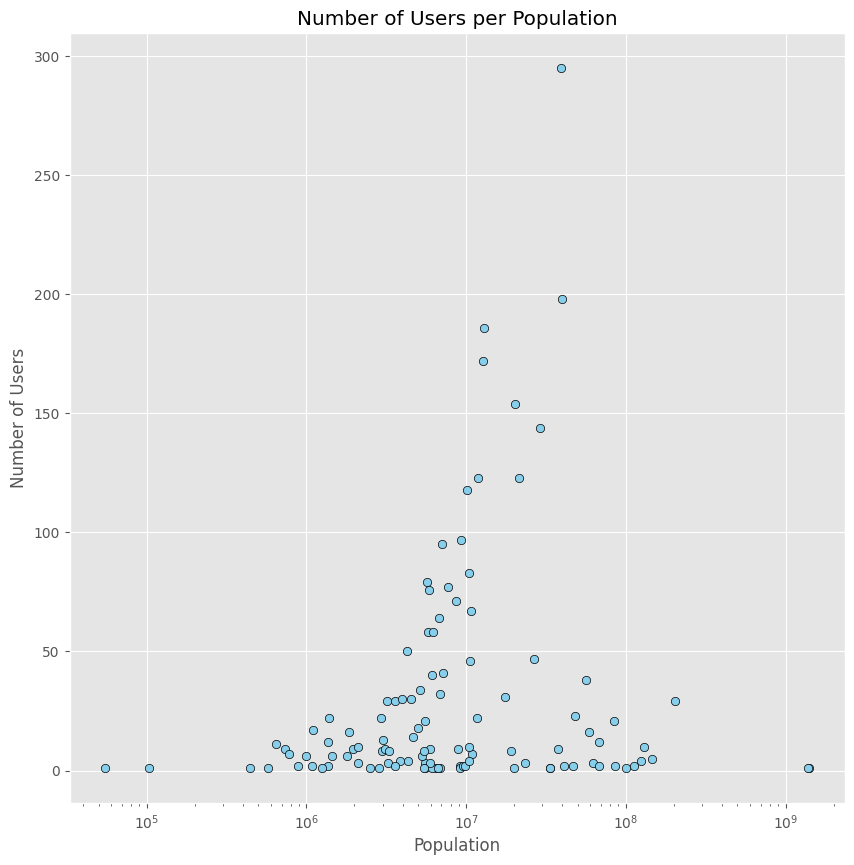

,location,user_id,population,users per capita
17,Faroe Islands,1,54738.0,0.000018
103,"United States, Vermont",11,643077.0,0.000017
87,"United States, New Hampshire",22,1377529.0,0.000016
97,"United States, Rhode Island",17,1097379.0,0.000015
96,"United States, Pennsylvania",186,13002700.0,0.000014
81,"United States, Minnesota",79,5706494.0,0.000014
79,"United States, Massachusetts",95,7029917.0,0.000014
71,"United States, Illinois",172,12812508.0,0.000013
107,"United States, Wisconsin",76,5893718.0,0.000013
60,"United States, Alaska",9,733391.0,0.000012


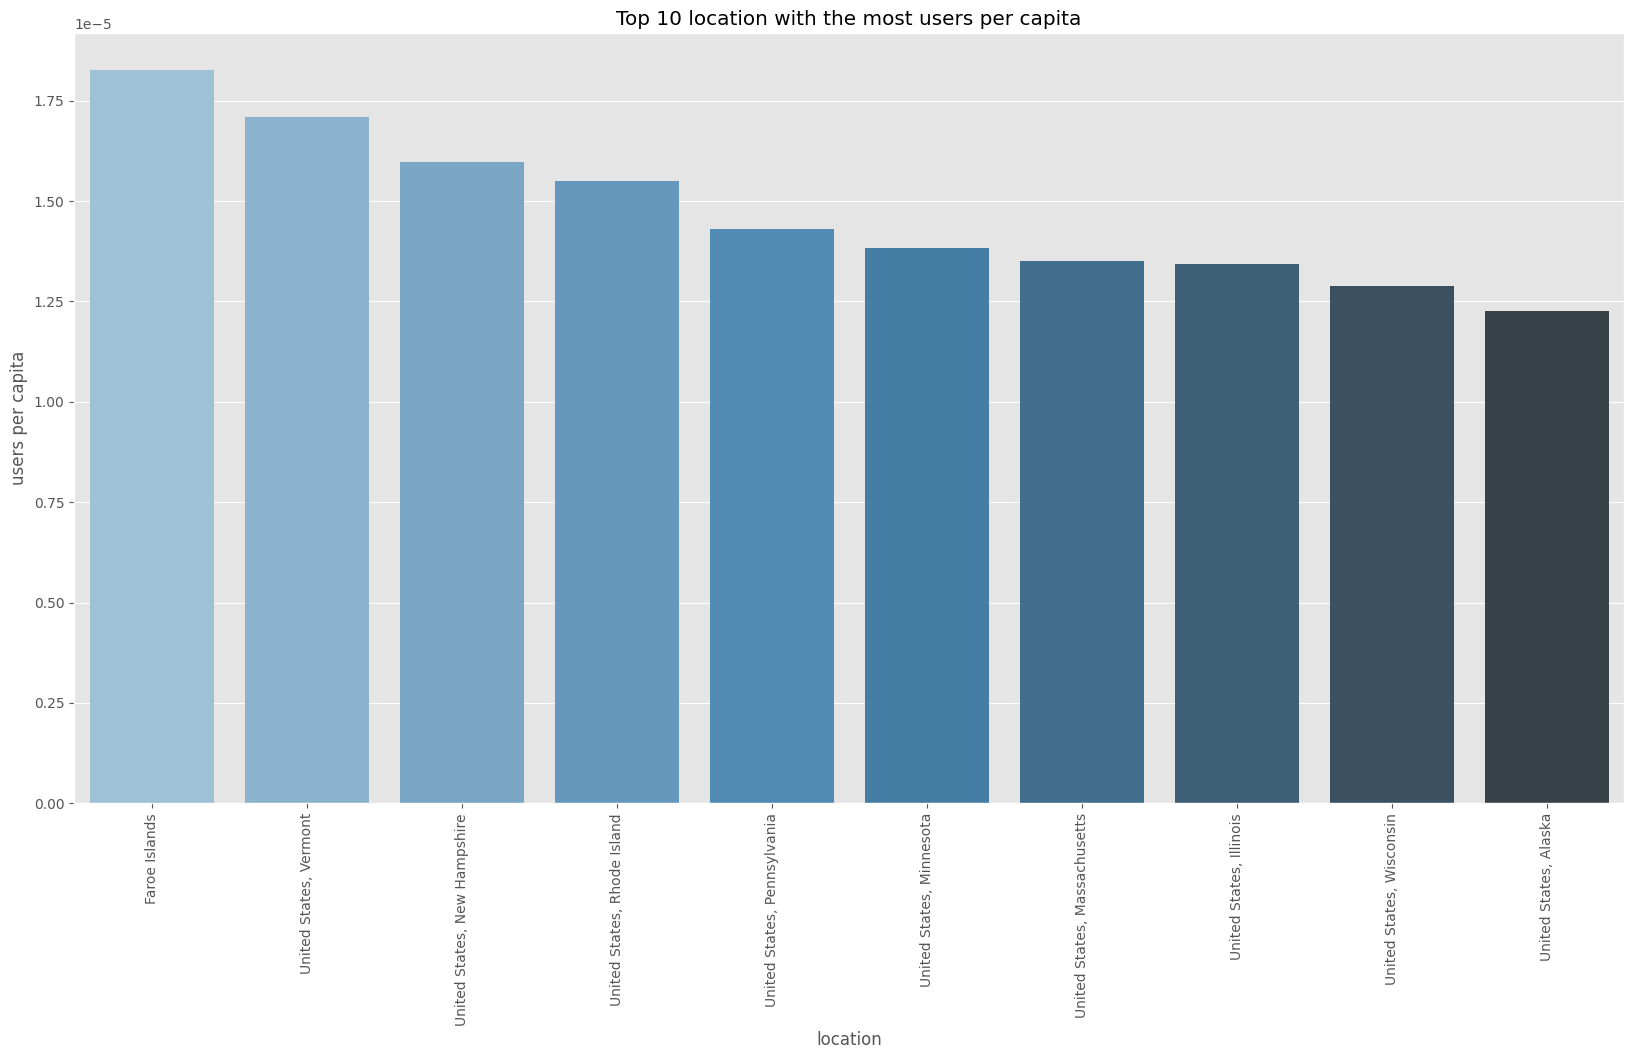

In [113]:
# Group the users by location and count the number of users in each location
df_users_pop_count_4graph = df_users_pop.groupby('location').user_id.count()

# Get the values of the population in each location 
df_users_pop_4graph = df_users_pop.groupby('location').population.mean()
display(df_users_pop_4graph)

# Plot the number of users per location
plt.figure(figsize=(10,10))
plt.scatter(df_users_pop_4graph, df_users_pop_count_4graph, color='skyblue', edgecolor='black')
plt.xlabel('Population')
plt.ylabel('Number of Users')
plt.xscale('log')
plt.title('Number of Users per Population')
plt.show()

# Concatenate the two dataframe to have access to users count per location and the respective population
df_users_pop_count = pd.concat([df_users_pop_count_4graph, df_users_pop_4graph], axis=1)
df_users_pop_count['users per capita'] = df_users_pop_count['user_id'] / df_users_pop_count['population']
df_users_pop_count.reset_index(inplace=True)
df_users_pop_count.sort_values(by=['users per capita'], ascending=False, inplace=True) 
top_ten_ratio = df_users_pop_count.head(10)
display(top_ten_ratio)

# Plot the number of users per location

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title('Top 10 location with the most users per capita')
sns.barplot(x='location', y='users per capita', data=top_ten_ratio, palette='Blues_d', hue='location')
plt.show()



**BREWERIES PER KM2**

location
Argentina                   2780400.0
Australia                   7692024.0
Austria                       83871.0
Belgium                       30689.0
Brazil                      8515767.0
                              ...    
United States, Wisconsin     169635.0
United States, Wyoming       253335.0
Uzbekistan                   448978.0
Vietnam                      331212.0
Wales                         20779.0
Name: km2, Length: 111, dtype: float64

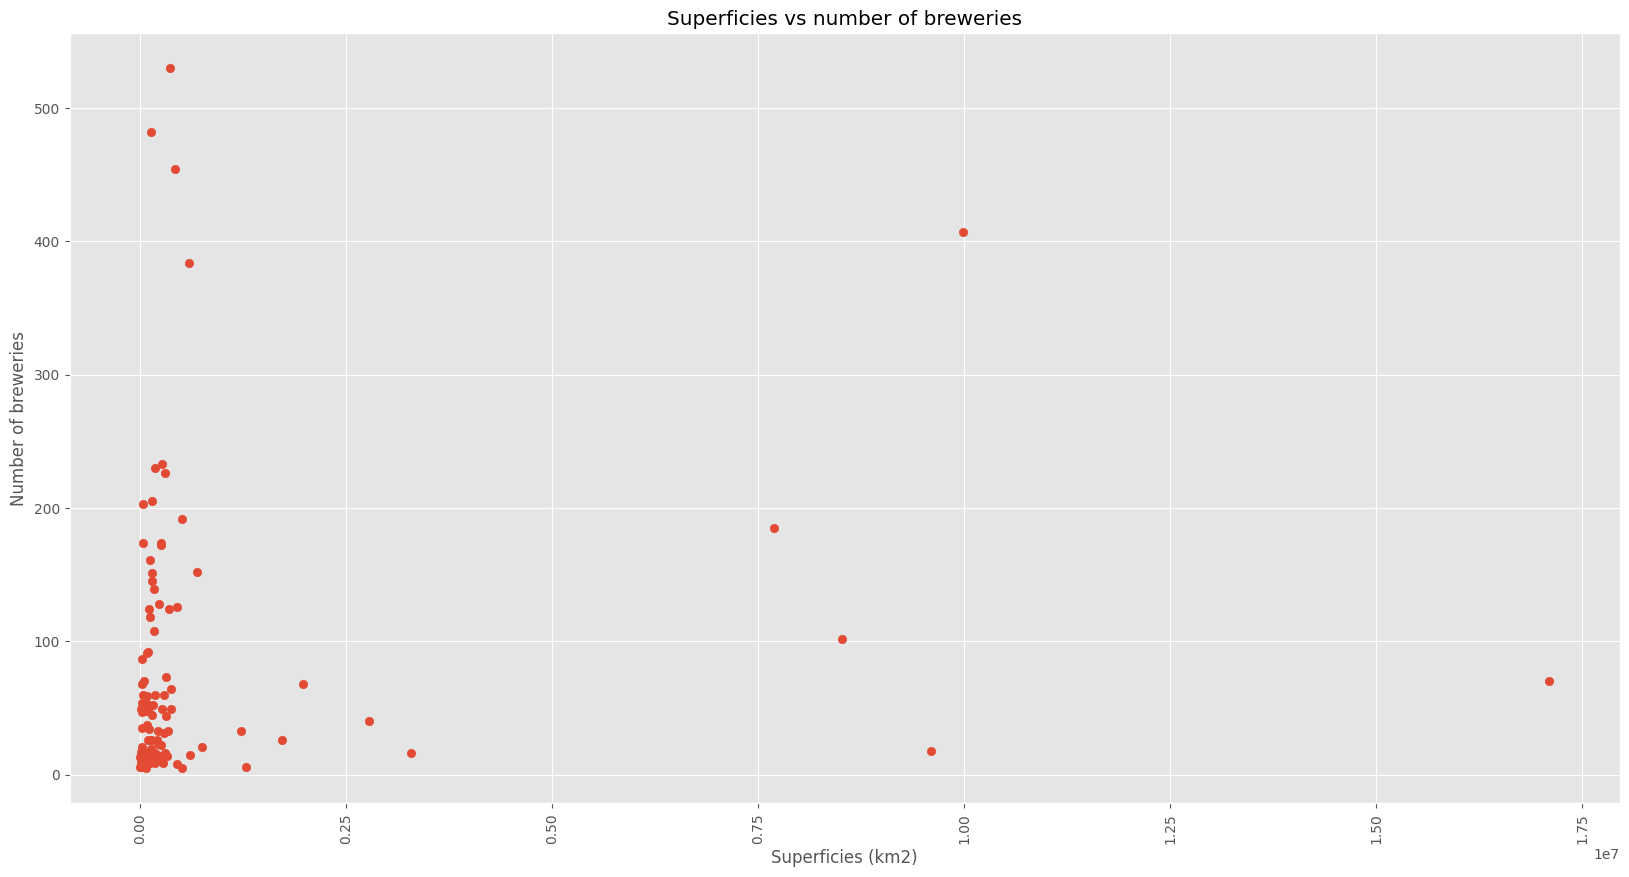

,location,id,km2,density
47,Singapore,6,728.0,0.008242
3,Belgium,203,30689.0,0.006615
34,Netherlands,174,41865.0,0.004156
16,England,482,130279.0,0.003700
64,"United States, Connecticut",49,14357.0,0.003413
96,"United States, Rhode Island",13,4001.0,0.003249
78,"United States, Massachusetts",87,27336.0,0.003183
87,"United States, New Jersey",68,22591.0,0.003010
102,"United States, Vermont",54,24906.0,0.002168
86,"United States, New Hampshire",47,24214.0,0.001941


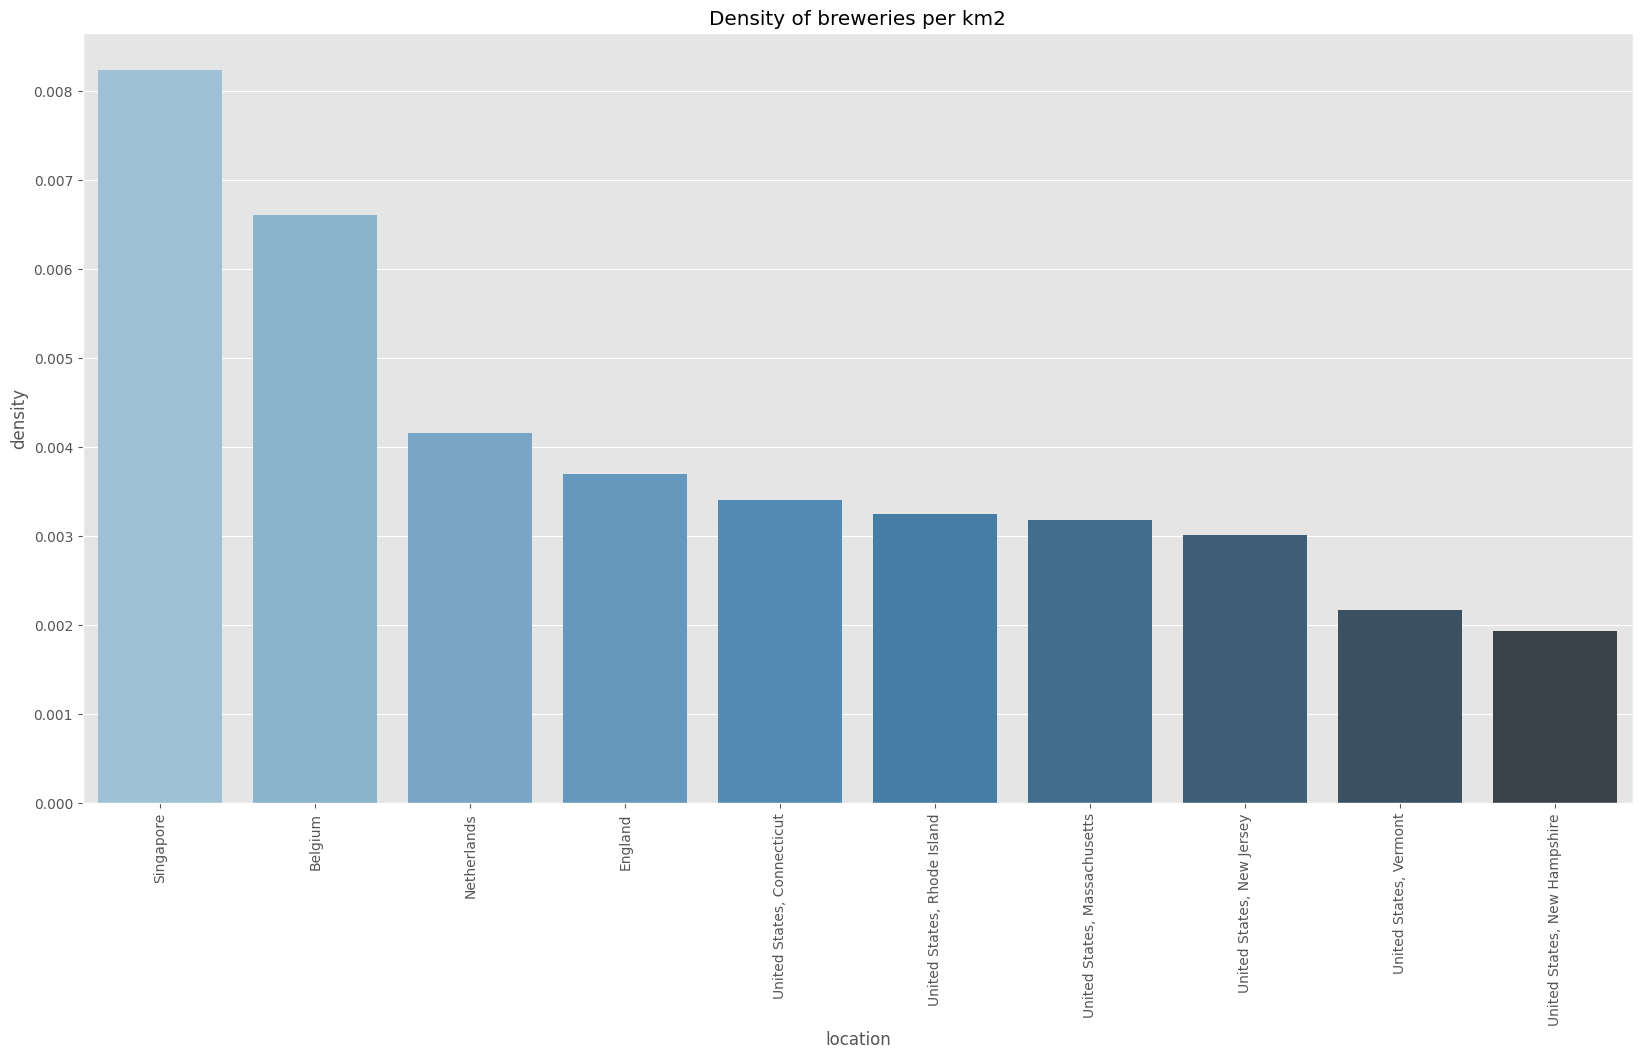

In [112]:
#Group the breweries by country, count the number of breweries and divide by the superfices of the location to have a density :
df_breweries_superficies_count = df_breweries_superficies_flt.groupby(['location']).id.count()
#display(df_breweries_superficies_flt)

#Get the values of the km2 in every location 
df_breweries_superficies_km2 = df_breweries_superficies_flt.groupby(['location']).km2.mean()
display(df_breweries_superficies_km2)

#Plot with superficies vs number of breweries
plt.figure(figsize=(20,10))
plt.scatter(df_breweries_superficies_km2, df_breweries_superficies_count)
plt.xlabel('Superficies (km2)')
plt.ylabel('Number of breweries')
plt.xticks(rotation=90)
plt.title('Superficies vs number of breweries')
plt.show()

#Concatenate the two dataframe to have access to the density of breweries per km2
df_density = pd.concat([df_breweries_superficies_count, df_breweries_superficies_km2], axis=1)
df_density['density'] = df_density['id'] / df_density['km2']
df_density.reset_index(inplace=True)
df_density.sort_values(by=['density'], ascending=False, inplace=True) 
top_ten_density = df_density.head(10)

#Plot the density of breweries per km2
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title('Density of breweries per km2')
sns.barplot(x='location', y='density', data=top_ten_density, palette='Blues_d', hue='location')
plt.show()

#Store the location of the top 10 density of breweries per km2
top_ten_density_location = top_ten_density['location']

#NO error bar because we don't have the standard deviation of the density of breweries per km2....



**THE PERCENTAGE OF ALCOHOL**

In [ ]:
#Drop the location with less than 5 beers (to do a beer trip, we need to have different beer to drink!) and beer with less than 20 ratings
df_beer_breweries_flt_abv = df_beer_breweries_clean.groupby('location').filter(lambda x: (len(x) >= 5) | (x['nbr_ratings'].sum() + x['nbr_ratings.1'].sum() >= 20)) 


,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Trinidad & Tobago,8.0,3.525000,1.971765,1.2,1.200,4.45,5.050,5.5
Bosnia and Herzegovina,3.0,3.666667,1.457166,2.0,3.150,4.30,4.500,4.7
Albania,1.0,4.100000,NaN,4.1,4.100,4.10,4.100,4.1
Jersey,5.0,4.100000,0.264575,3.7,4.000,4.20,4.200,4.4
Cuba,2.0,4.250000,0.353553,4.0,4.125,4.25,4.375,4.5
Lebanon,2.0,4.350000,2.333452,2.7,3.525,4.35,5.175,6.0
Malawi,3.0,4.466667,1.078579,3.7,3.850,4.00,4.850,5.7
Uzbekistan,12.0,4.475000,0.601702,3.4,4.225,4.40,5.000,5.4
Isle of Man,4.0,4.650000,1.297433,3.7,3.775,4.20,5.075,6.5


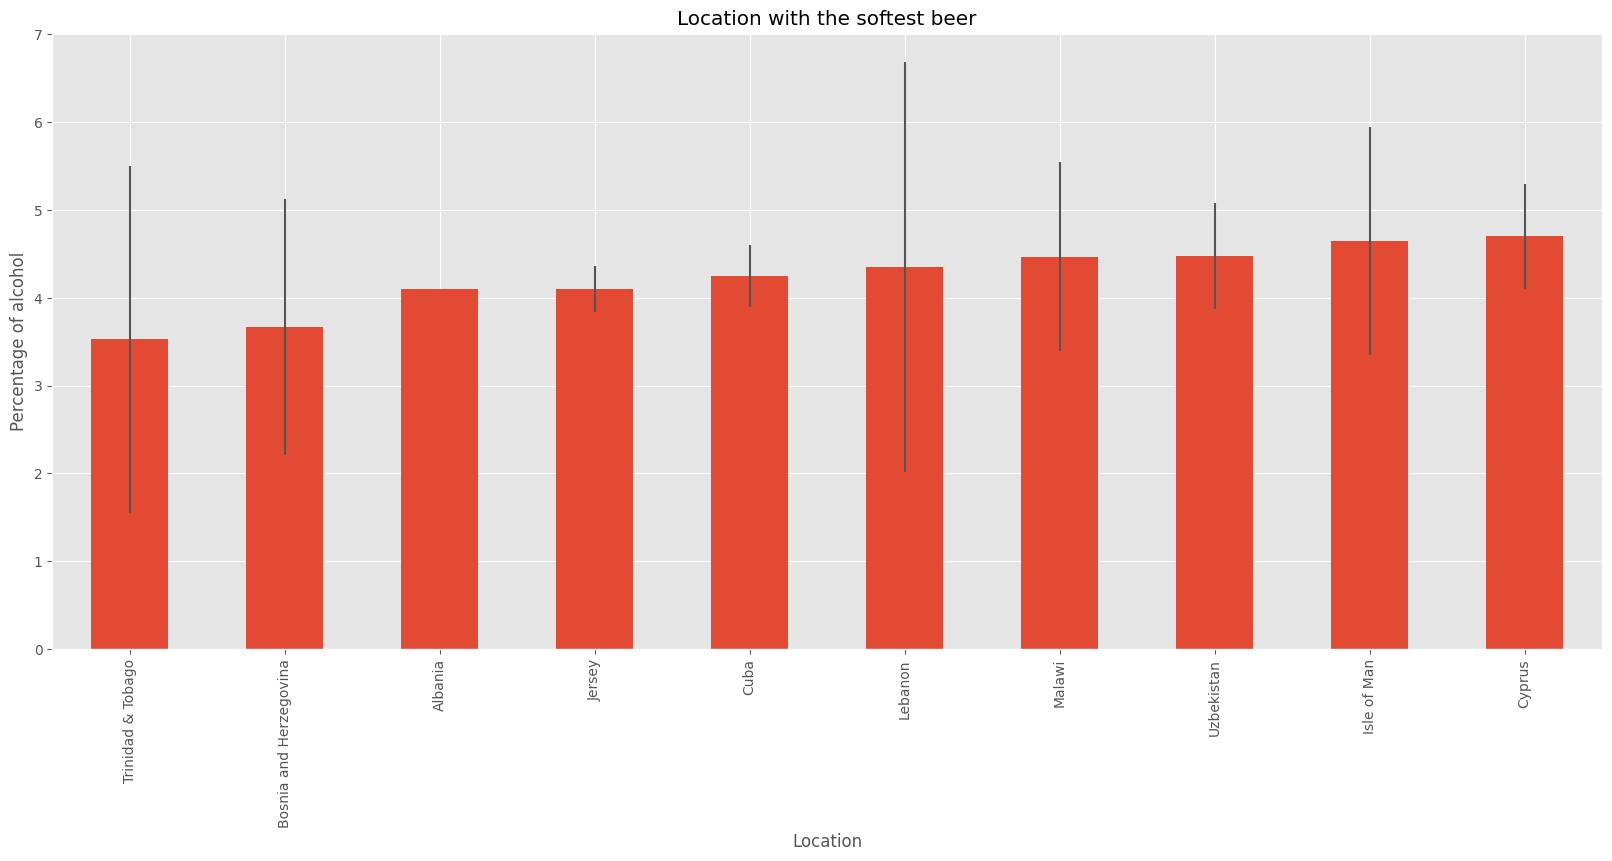

In [ ]:
#Sort the dataframe by considering the 10 location with the softest beer
avg_rating_location = df_beer_breweries_flt_abv.groupby('location').abv.describe()
avg_rating_location.sort_values(by='mean', ascending=True, inplace=True)
top_ten_abv_soft = avg_rating_location.head(10)
display(top_ten_abv_soft)

#Plot the result with standard deviation as error bar
pl = top_ten_abv_soft['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_abv_soft['std']) #mieux de faire avec CI ?????
pl.set_title('Location with the softest beer')
pl.set_ylabel('Percentage of alcohol')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_abv_soft.index, rotation=90)


#Keep a copy the ranking 
top_ten_abv_only_location = top_ten_abv_soft.index 


,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Egypt,4.0,7.675000,2.736634,4.7,5.675,8.00,10.000,10.0
Estonia,69.0,7.482609,2.704080,3.8,5.500,6.90,8.900,16.0
Belgium,863.0,7.115435,2.328768,0.5,6.000,7.00,8.000,39.0
Iceland,45.0,7.108889,2.644619,4.0,5.200,6.00,9.000,14.5
"United States, Rhode Island",143.0,7.013566,2.198081,2.5,5.500,6.60,8.000,12.5
Netherlands,569.0,7.005290,2.022058,0.5,5.600,6.60,8.200,20.0
"United States, Oklahoma",90.0,6.880000,2.655933,3.7,5.075,6.25,8.000,17.0
"United States, Georgia",461.0,6.852278,1.906642,3.0,5.300,6.50,8.100,13.9
Mauritius,12.0,6.825000,2.100271,4.8,5.600,6.20,7.375,12.0


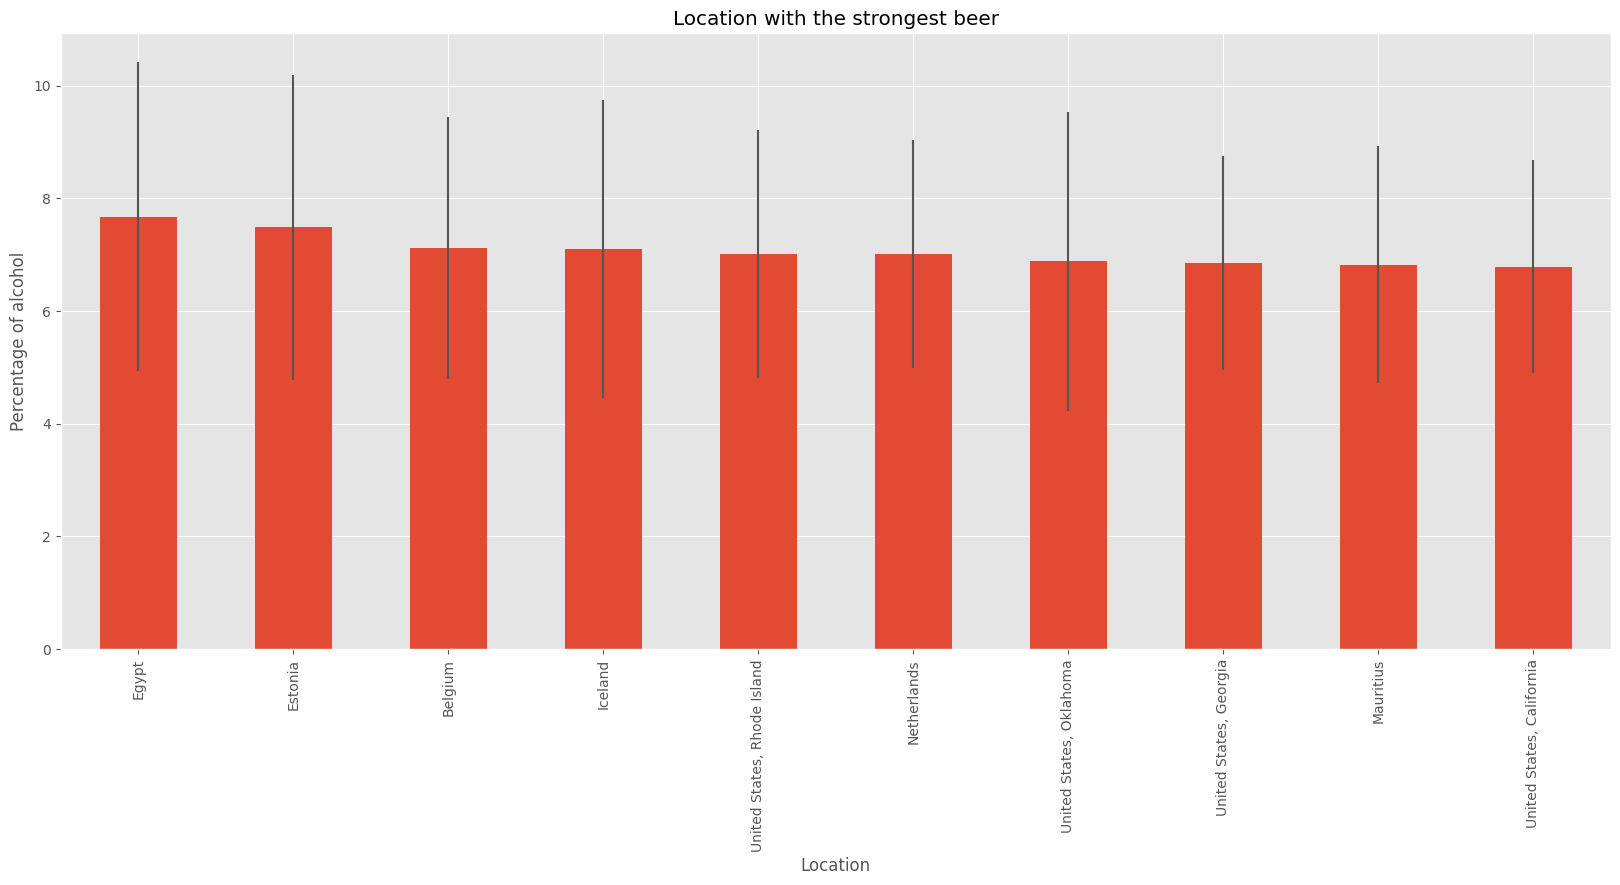

In [ ]:
#Sort the dataframe by considering the 10 location with the strongest beer
avg_rating_location = df_beer_breweries_flt_abv.groupby('location').abv.describe()
avg_rating_location.sort_values(by='mean', ascending=False, inplace=True)
top_ten_abv_strong = avg_rating_location.head(10)
display(top_ten_abv_strong)

#Plot the result with standard deviation as error bar
pl = top_ten_abv_strong['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_abv_strong['std']) #mieux de faire avec CI ?????
pl.set_title('Location with the strongest beer')
pl.set_ylabel('Percentage of alcohol')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_abv_strong.index, rotation=90)

#Keep a copy the ranking 
top_ten_abv_only_location = top_ten_abv_strong.index 


**THE RATINGS IN GLOBAL**

(162,)


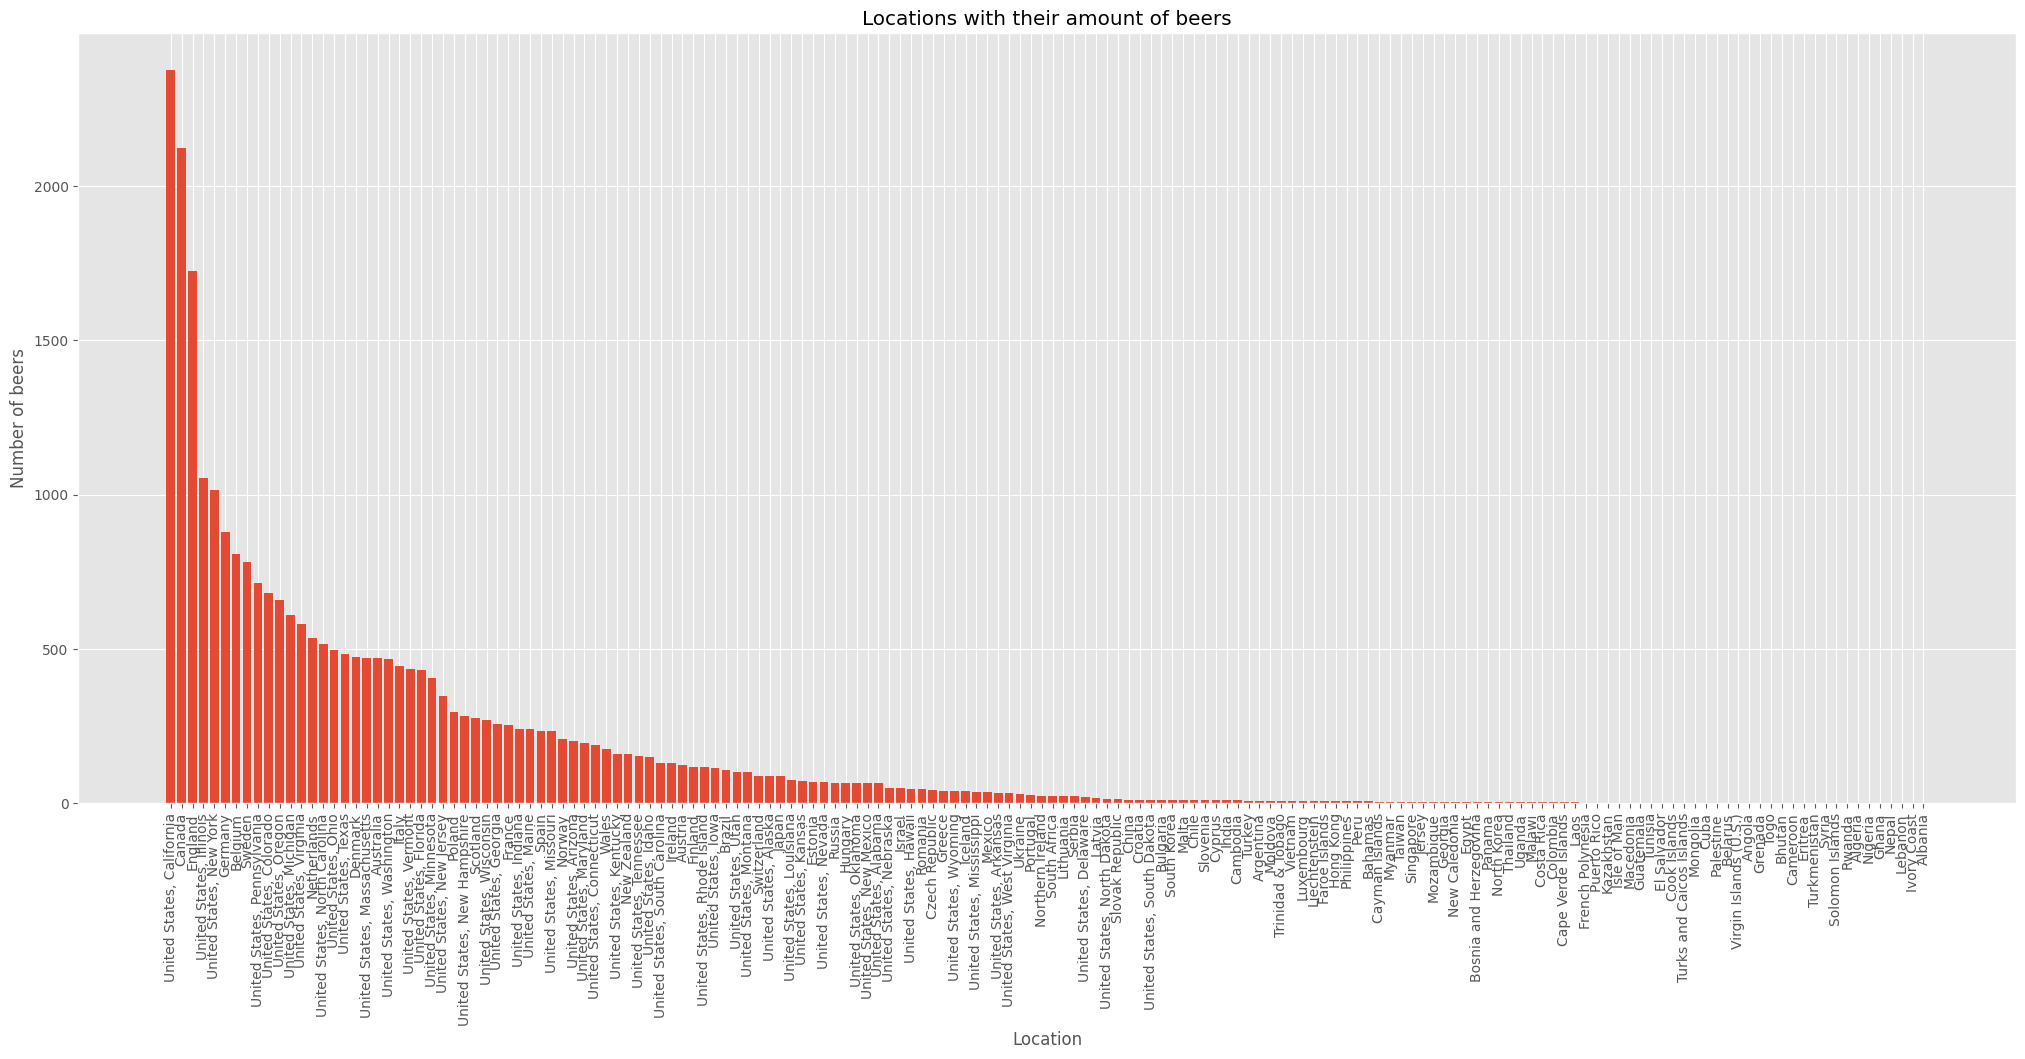

In [ ]:
#Select only the beers with at least 5 ratings on either sites (RateBeer and Beer Advocate), because we want to have a good idea of the quality of the beers: 
df_beer_breweries_clean_5_plus = df_beer_breweries_clean[(df_beer_breweries_clean['nbr_ratings'] >=5) | (df_beer_breweries_clean['nbr_ratings.1'] >=5)]

#Grouped the beers by location and count the number of beers in each location
df_beer_breweries_clean_5_plus_4plot = df_beer_breweries_clean_5_plus.groupby('location').beer_name.count()
print(df_beer_breweries_clean_5_plus_4plot.shape)

#Plot the location with the most beers with at least 5 ratings on each sites wiht location name on the x axis and from to bigger to the lower
index = df_beer_breweries_clean_5_plus_4plot.sort_values(ascending=False).index
beers = df_beer_breweries_clean_5_plus_4plot.sort_values(ascending=False)

plt.figure(figsize=(25,10))
plt.bar(index, beers)
plt.title('Locations with their amount of beers')
plt.xlabel('Location')
plt.ylabel('Number of beers')
plt.xticks(rotation=90)
plt.show()


We can see on the previous graph that we still have a lot of location to visit after keeping only the beers with more than 5 ratings on both websites, but we can restrain even more this number by imposing conditions on the minimum amount of beers in a location to be considered as a potential destination for the trip. 

(95,)


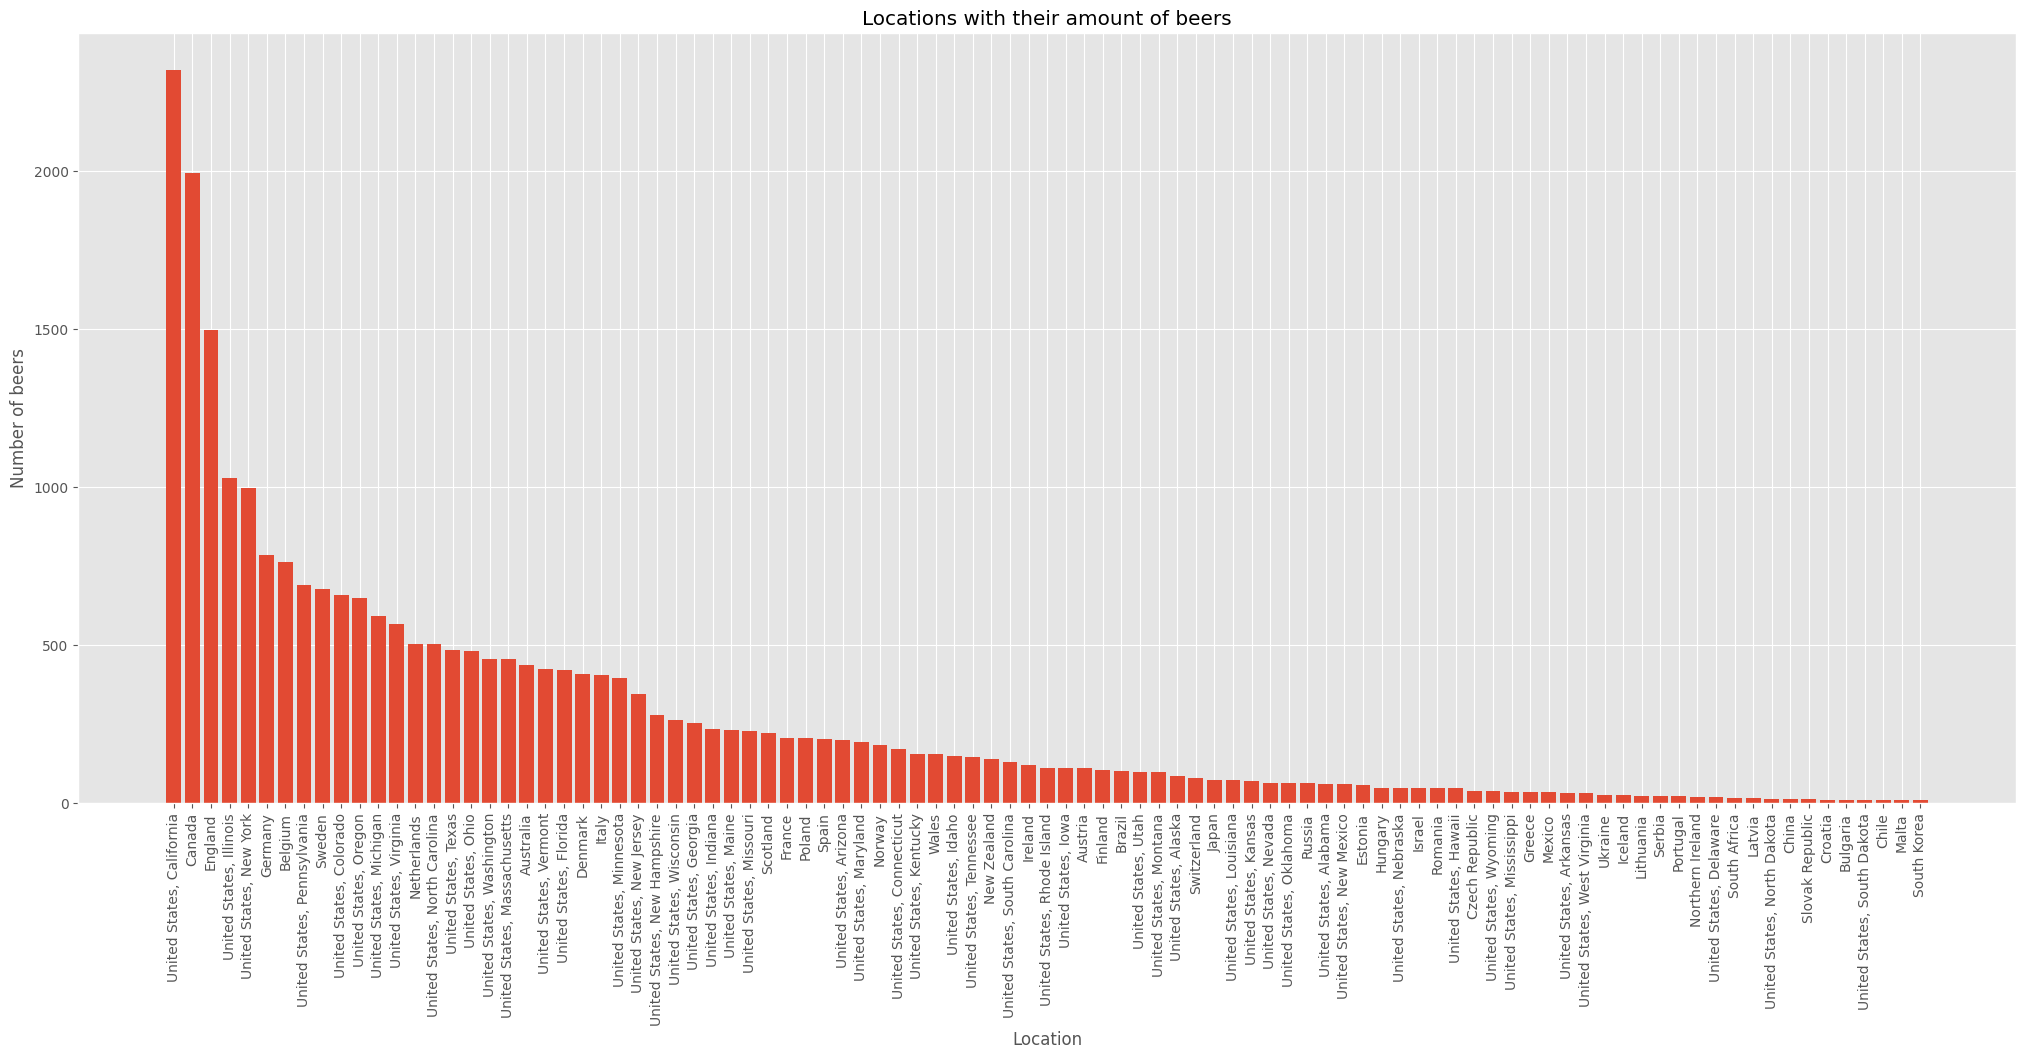

In [ ]:
#Drop the beers with no zscore in either sites
df_beer_breweries_clean_5_plus = df_beer_breweries_clean_5_plus.drop(df_beer_breweries_clean_5_plus[(df_beer_breweries_clean_5_plus['zscore'].isna()) | (df_beer_breweries_clean_5_plus['zscore.1'].isna())].index)

#Drop the location with less than 10 different beers (to do a beer trip, we need to have different beer to drink!)
df_beer_breweries_flt = df_beer_breweries_clean_5_plus.groupby('location').filter(lambda x: len(x) >= 10)

#Plot the location with more than 5 beers produced and with at least 5 ratings on each sites
df_beer_breweries_flt_4plot = df_beer_breweries_flt.groupby('location').beer_name.count()
print(df_beer_breweries_flt_4plot.shape)

index = df_beer_breweries_flt_4plot.sort_values(ascending=False).index
beers = df_beer_breweries_flt_4plot.sort_values(ascending=False)

plt.figure(figsize=(25,10))
plt.bar(index, beers)
plt.title('Locations with their amount of beers')
plt.xlabel('Location')
plt.ylabel('Number of beers')
plt.xticks(rotation=90)
plt.show()



We still have 95 destinations for our trip. It is a good number to start with! Now lets analysis the data relatively to the ratings and the best way is to analyse the zscore of the beers. Indeed, the z-score basically makes the ratings comparable both across websites and time in general. However, in order to have a representative overall zscore, we will average the ones from BeerAdvocate and Rate Beer by taking into account their amount of ratings. 

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
"United States, Maine",231.0,0.183846,0.473111,-1.518077,-0.102519,0.166365,0.513198,1.362519
"United States, Vermont",426.0,0.125832,0.574776,-1.837734,-0.237652,0.133906,0.563873,1.516792
"United States, California",2320.0,0.107166,0.515948,-3.199859,-0.203632,0.129826,0.466887,1.415517
"United States, New Mexico",61.0,0.062844,0.617193,-1.590671,-0.326977,0.114137,0.559598,1.172282
"United States, Georgia",253.0,0.045996,0.462134,-1.311436,-0.247329,0.045842,0.353078,1.344551
Estonia,59.0,0.036721,0.567130,-1.118227,-0.462741,0.026469,0.432350,1.091648
"United States, Alaska",87.0,0.006421,0.462141,-1.320580,-0.279923,-0.025459,0.331573,1.052375
"United States, New York",996.0,-0.011019,0.469878,-1.680847,-0.293767,0.026104,0.321323,1.077818
"United States, Illinois",1029.0,-0.037431,0.429992,-2.416453,-0.295651,-0.026500,0.250733,1.230551


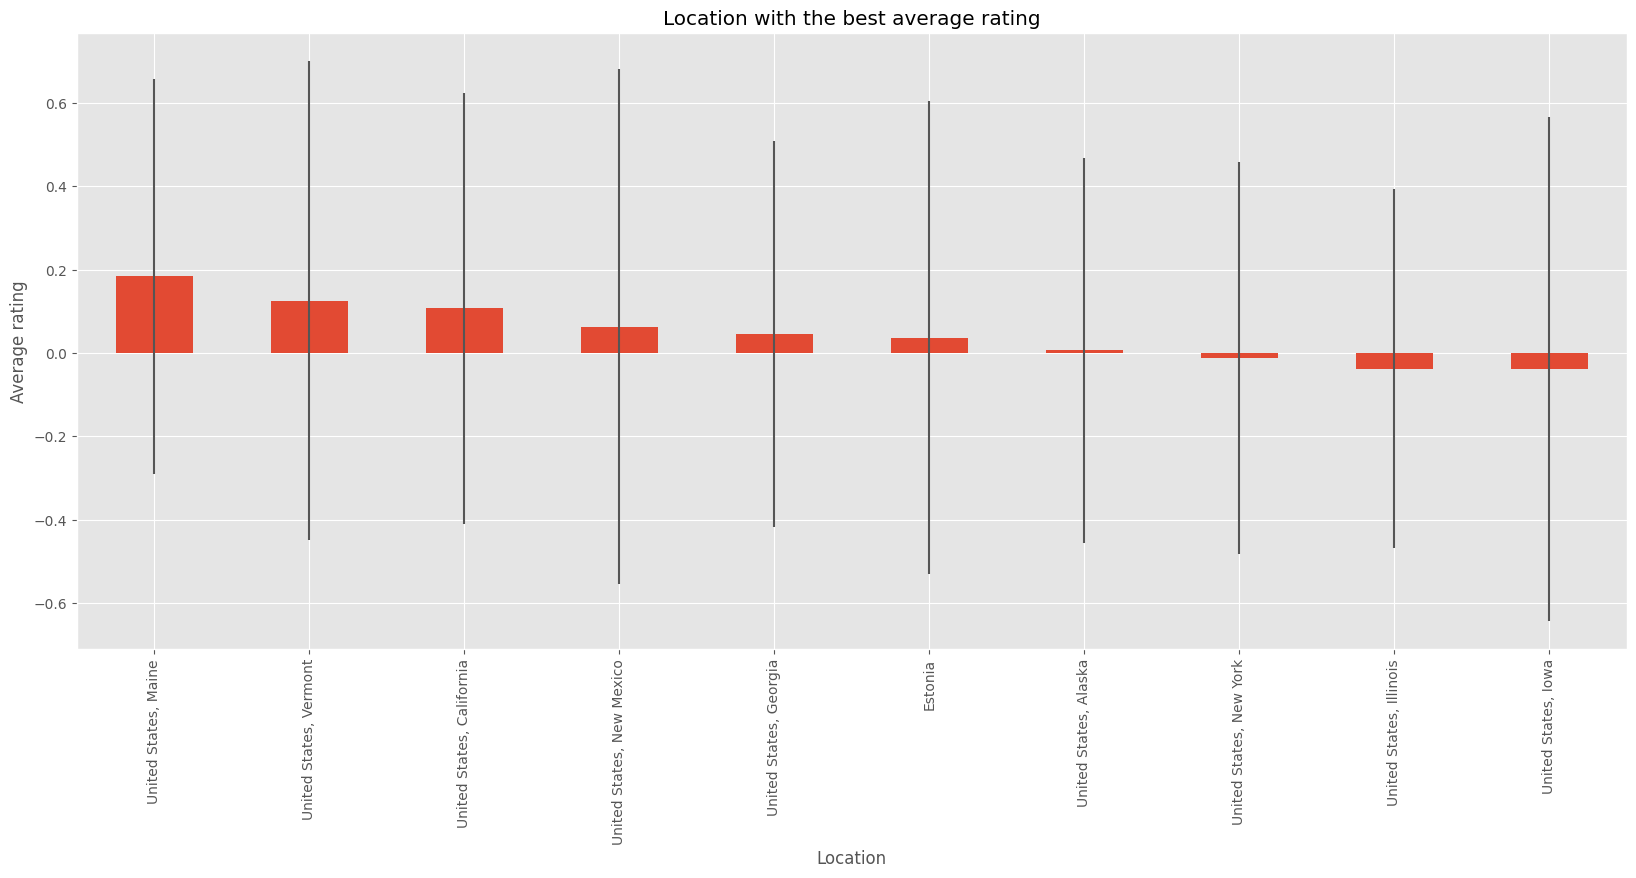

In [ ]:
#Compute the beers'average rating on the two website by creating new columns
df_beer_breweries_flt['total_rating'] = df_beer_breweries_flt['nbr_ratings'] + df_beer_breweries_flt['nbr_ratings.1']
df_beer_breweries_flt['zscore_common'] = df_beer_breweries_flt['nbr_ratings']/df_beer_breweries_flt['total_rating'] * df_beer_breweries_flt['zscore'] + df_beer_breweries_flt['nbr_ratings.1'] / df_beer_breweries_flt['total_rating'] * df_beer_breweries_flt['zscore.1']


#Sort the dataframe by considering the 10 location with the best average rating
avg_rating_location = df_beer_breweries_flt.groupby('location').zscore_common.describe()
avg_rating_location.sort_values(by='mean', ascending=False, inplace=True)
top_ten_best = avg_rating_location.head(10)
display(top_ten_best)


#Plot the result with stndard deviation as error bar
pl = top_ten_best['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_best['std'])
pl.set_title('Location with the best average rating')
pl.set_ylabel('Average rating')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_best.index, rotation=90)

#Keep a copy the ranking 
top_ten_best_only_location = top_ten_best.index 



As we can see on the barplot above, the standard deviation in each location is quite huge. It shows that is a location, there are well-rated beers, but also some that are badly rated. The precision of this not good, but still give a good idea of the regions where the overall ratings of the beers is high.

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Lithuania,23.0,-1.425476,0.630819,-2.724032,-1.868994,-1.269317,-0.941136,-0.392230
Malta,10.0,-1.180339,0.818195,-2.410861,-1.938667,-0.921097,-0.495975,-0.277015
Greece,35.0,-1.148942,0.905444,-3.180170,-1.714084,-1.127349,-0.436014,0.483792
Bulgaria,11.0,-1.120384,0.932687,-2.935601,-1.811626,-0.776093,-0.328896,-0.273884
Mexico,34.0,-0.924306,0.641137,-2.454270,-1.225178,-0.733734,-0.448827,0.308954
Ukraine,26.0,-0.908454,1.002142,-3.243719,-1.377662,-0.573328,-0.357755,0.575054
Serbia,22.0,-0.861378,0.937381,-2.512200,-1.649881,-0.463577,-0.083670,0.248760
Croatia,11.0,-0.794280,1.242638,-2.493899,-1.992869,-0.131413,0.300526,0.567897
Spain,203.0,-0.713136,0.773352,-3.008873,-1.275675,-0.643853,-0.124416,0.836810


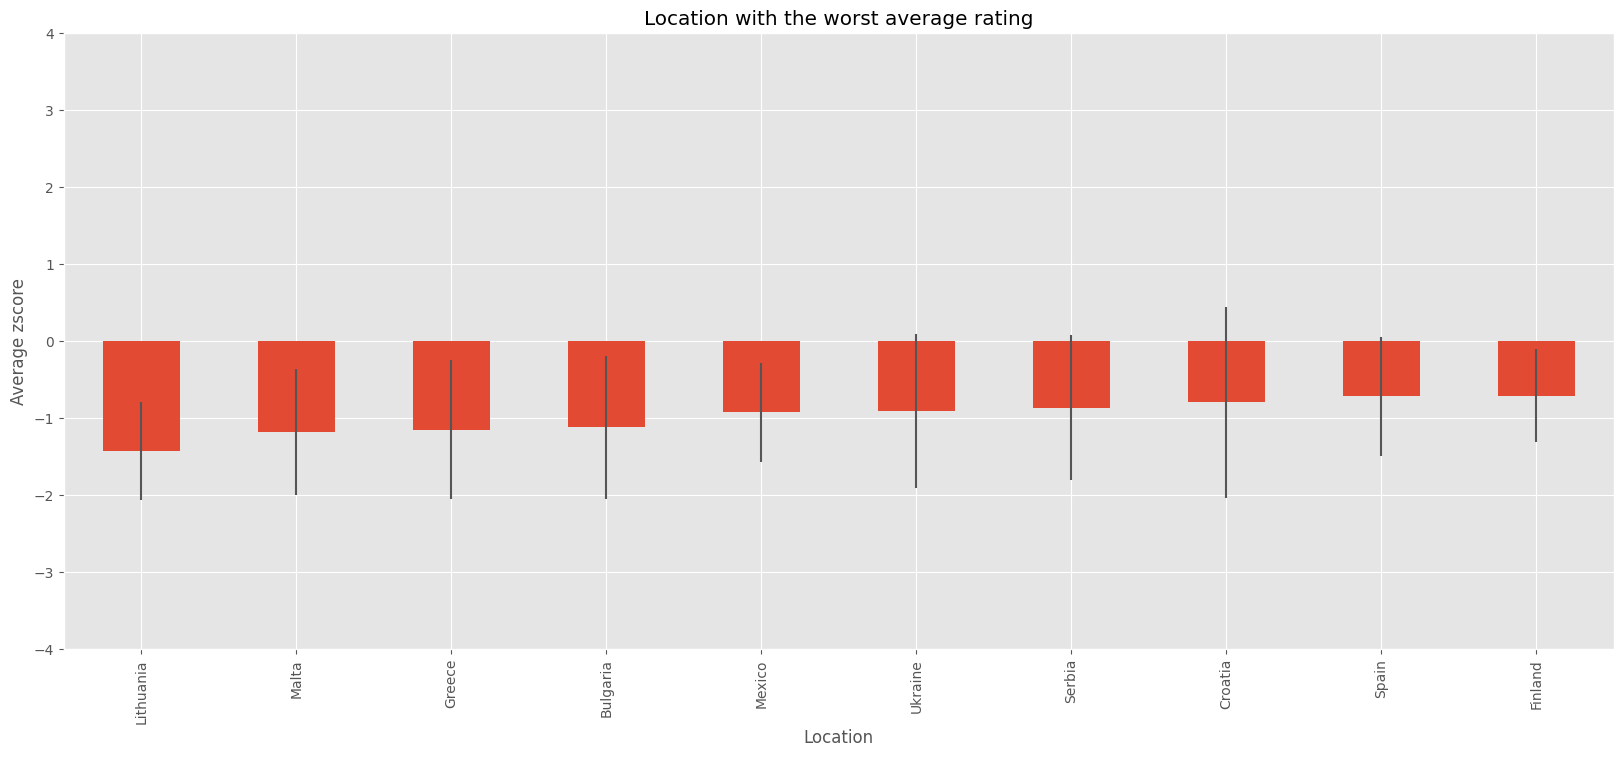

In [ ]:
#Sorted the location considering the 10 location with the worst average rating and plot the result
avg_rating_location = df_beer_breweries_flt.groupby('location').zscore_common.describe()
avg_rating_location.sort_values(by='mean', ascending=True, inplace=True)
top_ten_worst = avg_rating_location.head(10)
display(top_ten_worst)


#Plot the result with stndard deviation as error bar
pl = top_ten_worst['mean'].plot(kind='bar', figsize=[20,8], rot=0, yerr=top_ten_worst['std'])
pl.set_title('Location with the worst average rating')
pl.set_ylabel('Average zscore')
pl.set_xlabel('Location')
pl.set_xticklabels(top_ten_worst.index, rotation=90)
pl.set_ylim([-4, 4])

#Keep a copy the ranking 
top_ten_worst_only_location = top_ten_worst.index 


This part is more for fun, because we have access to the worst locations, so why not to have a look at it!


**THE NUMBER OF USERS PER CAPITA**

This part is not finish yet, because we need to import a dataframe from Wikipedia with the population from every location in order to compute the amount of user per individual. Then we are going to rank the region of the world with respect to the ones having a lot of reviewers in the population (in those countries, you are more likely to find people that love beers !)

In [ ]:
#To determine the locations where the population is the most passionate by beer. 
#We thought about computing the amount of reviewers per location relatively to the population of the location.
df_users_approx_flt


,location,user_id,user_name,nbr_ratings_beer_advocate,nbr_ratings_ratebeer
0,Spain,magicuenca.1185749,MAGICuenca,3,89
1,Germany,erzengel.248045,Erzengel,6,8781
2,"United States, Virginia",gendv138.695700,GenDV138,1,6240
3,"United States, Washington",nimbleprop.208928,nimbleprop,3,7452
4,Estonia,visionthing.639993,visionthing,11,5462
...,...,...,...,...,...
3336,"United States, Michigan",ypsifly.8833,ypsifly,587,1
3337,"United States, Texas",hardtarget.1712,HardTarget,1379,1
3338,"United States, Delaware",deadterry.13629,DeadTerry,1,2
3339,Vietnam,nelsonsaigon.897449,nelsonsaigon,176,1


## Calculation of the overall ranking: 

### Illustration of the trips on a world map 

Not finish yet, it the part where we will show the trips given by each thematic. Here is a small exemple to visualize the common zscore (computed for each location)

TO DO (for Milestone P3): 
We want to illustrate the trips relatively to the features on a map of the world to visualize well the steps of the trips. 

In [ ]:
#Visualization of the dataframe computed above

tmp = df_beer_breweries_flt.groupby('location').size().reset_index(name='count')
new = df_beer_breweries_flt.groupby('location').zscore_common.mean().reset_index().dropna()

# To fit the state names, we need to rename some of them by removing the country name
new.location = new.location.str.replace('United States, ', '')

#add the count column to the new df
new = pd.merge(new, tmp, on='location', how='left')

#plotly doesn't recognise mauritius so we drop it and we need to add the correct names for the UK countries
new = new[new['location'] != 'Mauritius']
new.location = new.location.replace({'England': 'GB-ENG', 'Scotland': 'GB-SCT', 'Wales': 'GB-WLS', 'Northern Ireland': 'GB-NIR'})


# Replace full state names with abbreviations because problem with plotly to import the package us
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
    'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }
new['location'] = new['location'].map(state_abbreviations).fillna(new['location'])

#sort new df by avg
new = new.sort_values(by=['zscore_common'], ascending=False)


In [ ]:
# Create a world map
#Problem to show the countries from the UK on the map
fig_world = px.choropleth(new, locations='location',
                          locationmode='country names', 
                          color='zscore_common', 
                          hover_name='location', 
                          color_continuous_scale=px.colors.sequential.Plasma,
                          scope='world',
                          projection = 'orthographic') 

fig_world.update_layout(title_text='World Map', coloraxis_colorbar=dict(title='Standardize ratings for each location'))
fig_world.show()

# Create a USA map
fig_usa = px.choropleth(new, locations='location',
                         locationmode='USA-states', 
                         color='zscore_common', 
                         hover_name='location', 
                         color_continuous_scale=px.colors.sequential.Plasma,
                         scope='usa') 

fig_usa.update_layout(title_text='USA map',coloraxis_colorbar=dict(title='Standardize ratings for each location')) 
fig_usa.show()

### Compute the overall ranking

This part is not finish yet, because we didn't build all the rankings (so we don't know how many weights we will need). But the idea is to ask couple questions to the customers in order to determine which rankings are important for them. Then, with respect to the answers given, we assign some weights in order to emphasize the importance of some rankings compare to the others. For the moment, we implement the function with 5 weights.

In [ ]:
#Compute the overall ranking based on the previous rankings (assume 10 rankings)
def overall_ranking(w1, w2, w3, w4, w5) :
    '''
    Plot the overall ranking based on the previous rankings and their respective weights, given by the customer. 
    The weights must be between 0 and 1 and must sum to 1.

    Args :
        w1 : weight of the ranking 1
        w2 : weight of the ranking 2
        w3 : weight of the ranking 3
        w4 : weight of the ranking 4
        w5 : weight of the ranking 5 
    '''
    # Add the point for each ranking 
    df_density_top10 = pd.DataFrame({'location': top_ten_density_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_bestratings_top10 = pd.DataFrame({'location': top_ten_best_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_worstratings_top10 = pd.DataFrame({'location': top_ten_worst_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})  
    df_strongest_abv_top10 = pd.DataFrame({'location': top_ten_abv_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})
    df_softest_abv_top10 = pd.DataFrame({'location': top_ten_abv_only_location, 'score' : [10,9,8,7,6,5,4,3,2,1]})

    # Apply the weights to the score
    df_density_top10['score'] = df_density_top10['score'] * w1
    df_bestratings_top10['score'] = df_bestratings_top10['score'] * w2
    df_worstratings_top10['score'] = df_worstratings_top10['score'] * w3
    df_strongest_abv_top10['score'] = df_strongest_abv_top10['score'] * w4
    df_softest_abv_top10['score'] = df_softest_abv_top10['score'] * w5

    # Merge all the dataframes
    df_overall = pd.merge(df_density_top10, df_bestratings_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_worstratings_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_strongest_abv_top10, on='location', how='outer')
    df_overall = pd.merge(df_overall, df_softest_abv_top10, on='location', how='outer')


### TO DO : 
# change the number in Args (docstring) by the name of the rankings (ex : % of alcohol, density of breweries, etc)
# plot the overall ranking
# return a dataframe with the overall ranking location (only location, don't need the score anymore)


### Find additional useful travel informations: 

TO DO (for Milestone P3): 
After having the overall ranking, we need to find the best breweries (the ones with the best beers) in each location and also the best users (the ones with the most ratings)